In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import Libraries**

In [10]:
!pip install pandas_ta mplcursors

In [11]:
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as ta
import seaborn as sns
import datetime
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Activation, GRU
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
from itertools import product
import mplcursors
from sklearn.cluster import DBSCAN
import tensorflow as tf
from tensorflow import keras
from keras.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping, LearningRateScheduler

### **PROVA**

In [ ]:
stock = yf.Ticker("AAPL")

df = stock.history(start="2022-05-04", end="2024-04-24", interval="1h")
display(df)

Open        High         Low       Close  \
Datetime                                                                    
2022-05-04 09:30:00-04:00  159.669998  161.300003  159.470001  160.000000   
2022-05-04 10:30:00-04:00  159.988693  160.539993  159.369995  159.536194   
2022-05-04 11:30:00-04:00  159.541107  161.568695  159.259995  161.449997   
2022-05-04 12:30:00-04:00  161.449997  162.210007  161.212494  161.869995   
2022-05-04 13:30:00-04:00  161.869995  163.720001  161.130005  162.270004   
...                               ...         ...         ...         ...   
2024-04-23 11:30:00-04:00  166.619995  166.699997  166.057404  166.270004   
2024-04-23 12:30:00-04:00  166.270004  166.639999  166.171707  166.391998   
2024-04-23 13:30:00-04:00  166.399994  166.860001  166.324997  166.839996   
2024-04-23 14:30:00-04:00  166.839996  166.869904  166.500000  166.850006   
2024-04-23 15:30:00-04:00  166.839996  167.050003  166.755005  166.910004   

                             Volume  Dividends  Stock Splits  
Datetime                                                      
2022-05-04 09:30:00-04:00  21334407        0.0           0.0  
2022-05-04 10:30:00-04:00   9393407        0.0           0.0  
2022-05-04 11:30:00-04:00   8945651        0.0           0.0  
2022-05-04 12:30:00-04:00   8158615        0.0           0.0  
2022-05-04 13:30:00-04:00  13713857        0.0           0.0  
...                             ...        ...           ...  
2024-04-23 11:30:00-04:00   3828132        0.0           0.0  
2024-04-23 12:30:00-04:00   4067219        0.0           0.0  
2024-04-23 13:30:00-04:00   2849527        0.0           0.0  
2024-04-23 14:30:00-04:00   3658150        0.0           0.0  
2024-04-23 15:30:00-04:00   5719471        0.0           0.0  

[3453 rows x 7 columns]

In [ ]:
df_ore = df.copy()

# Reimposta l'indice del DataFrame in una colonna standard
df_ore.reset_index(inplace=True)

# Estrai la data e l'ora
df_ore['Date'] = df_ore['Datetime'].dt.date
df_ore['Time'] = df_ore['Datetime'].dt.time

# Rimuovi la parte del fuso orario se non è necessaria
df_ore['Datetime'] = df_ore['Datetime'].dt.tz_localize(None)

df_ore.drop(['Dividends', 'Stock Splits', 'Datetime'], axis=1, inplace=True)
display(df_ore)

Open        High         Low       Close    Volume        Date  \
0     159.669998  161.300003  159.470001  160.000000  21334407  2022-05-04   
1     159.988693  160.539993  159.369995  159.536194   9393407  2022-05-04   
2     159.541107  161.568695  159.259995  161.449997   8945651  2022-05-04   
3     161.449997  162.210007  161.212494  161.869995   8158615  2022-05-04   
4     161.869995  163.720001  161.130005  162.270004  13713857  2022-05-04   
...          ...         ...         ...         ...       ...         ...   
3448  166.619995  166.699997  166.057404  166.270004   3828132  2024-04-23   
3449  166.270004  166.639999  166.171707  166.391998   4067219  2024-04-23   
3450  166.399994  166.860001  166.324997  166.839996   2849527  2024-04-23   
3451  166.839996  166.869904  166.500000  166.850006   3658150  2024-04-23   
3452  166.839996  167.050003  166.755005  166.910004   5719471  2024-04-23   

          Time  
0     09:30:00  
1     10:30:00  
2     11:30:00  
3     12:30:00  
4     13:30:00  
...        ...  
3448  11:30:00  
3449  12:30:00  
3450  13:30:00  
3451  14:30:00  
3452  15:30:00  

[3453 rows x 7 columns]

In [ ]:
# Conta il numero di occorrenze di ciascuna data
counts_per_date = df_ore['Date'].value_counts()

# Filtra le date che non si ripetono sette volte
unique_dates = counts_per_date[counts_per_date != 7]
print("Date che non si ripetono sette volte:", unique_dates, '\n')

# Seleziona le righe del DataFrame corrispondenti a queste date
unique_dates_i = counts_per_date[counts_per_date != 7].index
filtered_rows = df_ore[df_ore['Date'].isin(unique_dates_i)]
display(filtered_rows)

num_unique_dates = df_ore['Date'].nunique()
print("\nNumero di valori unici nella colonna 'Date':", num_unique_dates)

Date che non si ripetono sette volte: Date
2022-11-25    3
2023-07-03    3
2023-11-24    3
Name: count, dtype: int64 



Open        High         Low       Close    Volume        Date  \
994   148.304993  148.880005  147.119995  148.399902  14640551  2022-11-25   
995   148.381805  148.399994  147.750000  147.825500   5463832  2022-11-25   
996   147.820007  148.409897  147.600006  148.169998   6310238  2022-11-25   
2033  193.779999  193.880005  192.800003  192.914993  12730490  2023-07-03   
2034  192.914993  192.929993  191.759995  192.354996   8267008  2023-07-03   
2035  192.360001  192.500000  192.039993  192.115005   3819693  2023-07-03   
2736  190.869995  190.899994  189.300003  189.460007   7873135  2023-11-24   
2737  189.470001  189.669998  189.250000  189.610001   4853829  2023-11-24   
2738  189.600006  189.788895  189.350006  189.539993   3827135  2023-11-24   

          Time  
994   09:30:00  
995   10:30:00  
996   11:30:00  
2033  09:30:00  
2034  10:30:00  
2035  11:30:00  
2736  09:30:00  
2737  10:30:00  
2738  11:30:00


Numero di valori unici nella colonna 'Date': 495


In [ ]:
# Calcola il numero di righe per ciascuna data
rows_per_date = df_ore['Date'].value_counts()

# Trova le date con meno di 7 righe
dates_with_missing_rows = rows_per_date[rows_per_date != 7].index

# Crea un DataFrame con tutte le ore desiderate
all_dates = pd.date_range(start=df_ore['Date'].min(), end=df_ore['Date'].max(), freq='D')
all_times = pd.date_range(start='09:30:00', end='15:30:00', freq='H').time
all_combinations = list(product(all_dates, all_times))
all_rows = pd.DataFrame(all_combinations, columns=['Date', 'Time'])

# Unisci il DataFrame originale con il DataFrame contenente le righe mancanti
df_with_missing_rows = pd.merge(all_rows.astype(str), df_ore.astype(str), on=['Date', 'Time'], how='left')

# Ordina il DataFrame per garantire che le righe siano in ordine cronologico
df_with_missing_rows = df_with_missing_rows.sort_values(by=['Date', 'Time']).reset_index(drop=True)

# Stampa il DataFrame con le righe mancanti aggiunte
display(df_with_missing_rows.head(35))

Date      Time                Open                High  \
0   2022-05-04  09:30:00   159.6699981689453   161.3000030517578   
1   2022-05-04  10:30:00   159.9886932373047   160.5399932861328   
2   2022-05-04  11:30:00  159.54110717773438  161.56869506835938   
3   2022-05-04  12:30:00   161.4499969482422   162.2100067138672   
4   2022-05-04  13:30:00   161.8699951171875  163.72000122070312   
5   2022-05-04  14:30:00  162.27000427246094  165.00999450683594   
6   2022-05-04  15:30:00  164.96499633789062  166.47999572753906   
7   2022-05-05  09:30:00  163.85000610351562  163.98989868164062   
8   2022-05-05  10:30:00  160.16000366210938  160.36000061035156   
9   2022-05-05  11:30:00  159.32000732421875  160.10000610351562   
10  2022-05-05  12:30:00  157.77999877929688  158.32000732421875   
11  2022-05-05  13:30:00  157.55340576171875  158.02000427246094   
12  2022-05-05  14:30:00  156.47000122070312   157.1999969482422   
13  2022-05-05  15:30:00  155.08999633789062   157.5800018310547   
14  2022-05-06  09:30:00  156.00999450683594   159.1649932861328   
15  2022-05-06  10:30:00   157.7449951171875  159.42999267578125   
16  2022-05-06  11:30:00   159.1699981689453  159.24000549316406   
17  2022-05-06  12:30:00   158.4499969482422  159.44000244140625   
18  2022-05-06  13:30:00  158.47999572753906  158.88999938964844   
19  2022-05-06  14:30:00  156.89500427246094               157.5   
20  2022-05-06  15:30:00  156.48550415039062   158.6999969482422   
21  2022-05-07  09:30:00                 NaN                 NaN   
22  2022-05-07  10:30:00                 NaN                 NaN   
23  2022-05-07  11:30:00                 NaN                 NaN   
24  2022-05-07  12:30:00                 NaN                 NaN   
25  2022-05-07  13:30:00                 NaN                 NaN   
26  2022-05-07  14:30:00                 NaN                 NaN   
27  2022-05-07  15:30:00                 NaN                 NaN   
28  2022-05-08  09:30:00                 NaN                 NaN   
29  2022-05-08  10:30:00                 NaN                 NaN   
30  2022-05-08  11:30:00                 NaN                 NaN   
31  2022-05-08  12:30:00                 NaN                 NaN   
32  2022-05-08  13:30:00                 NaN                 NaN   
33  2022-05-08  14:30:00                 NaN                 NaN   
34  2022-05-08  15:30:00                 NaN                 NaN   

                   Low               Close    Volume  
0   159.47000122070312               160.0  21334407  
1    159.3699951171875  159.53619384765625   9393407  
2   159.25999450683594   161.4499969482422   8945651  
3   161.21249389648438   161.8699951171875   8158615  
4    161.1300048828125  162.27000427246094  13713857  
5   159.66000366210938   164.9499969482422  23620691  
6   164.88999938964844   166.1199951171875  15363091  
7   160.00999450683594   160.1699981689453  21705285  
8    158.8350067138672  159.32000732421875  16613887  
9   157.27000427246094   157.8000030517578  17279582  
10  156.57000732421875  157.55999755859375  13632306  
11   156.4499969482422  156.47500610351562  11178364  
12  155.02000427246094   155.0800018310547  14907894  
13   154.9499969482422   156.8000030517578  20760292  
14   154.2100067138672  157.74000549316406  29113838  
15  156.63999938964844  159.17999267578125  16983290  
16   157.3000030517578   158.4600067138672  13220827  
17  157.80999755859375  158.47000122070312  10806371  
18               156.5  156.89500427246094   9804491  
19   155.8000030517578  156.47999572753906  11978833  
20  156.43099975585938  157.27999877929688  14452268  
21                 NaN                 NaN       NaN  
22                 NaN                 NaN       NaN  
23                 NaN                 NaN       NaN  
24                 NaN                 NaN       NaN  
25                 NaN                 NaN       NaN  
26                 NaN                 NaN       NaN  
27                 Na

In [ ]:
# Conta il numero di occorrenze di ciascuna data
counts_per_date = df_with_missing_rows['Date'].value_counts()

# Filtra le date che non si ripetono sette volte
unique_dates = counts_per_date[counts_per_date != 7]
print("Date che non si ripetono sette volte:", unique_dates)

num_unique_dates = df_with_missing_rows['Date'].nunique()
print("\nNumero di valori unici nella colonna 'Date':", num_unique_dates)

Date che non si ripetono sette volte: Series([], Name: count, dtype: int64)

Numero di valori unici nella colonna 'Date': 721


In [ ]:
# Converti la colonna 'Date' in tipo datetime se non lo è già
df_with_missing_rows['Date'] = pd.to_datetime(df_with_missing_rows['Date'])

# Ottieni tutti i valori unici delle date presenti nella colonna 'Date'
unique_dates = df_with_missing_rows['Date'].dt.date.unique()

# Ottieni l'elenco completo dei giorni tra le date minima e massima presenti nel DataFrame
all_dates = pd.date_range(start=df_with_missing_rows['Date'].min(), end=df_with_missing_rows['Date'].max()).date

# Trova i giorni non presenti nell'elenco delle date uniche
missing_dates = [date for date in all_dates if date not in unique_dates]

# Stampa i giorni non presenti nell'elenco delle date uniche
print("Giorni non presenti nell'elenco delle date uniche:")
display(missing_dates)

Giorni non presenti nell'elenco delle date uniche:


[]

In [ ]:
# Converti le colonne numeriche in float se non lo sono già
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df_with_missing_rows[numeric_columns] = df_with_missing_rows[numeric_columns].astype(float)

# Usa il metodo interpolate per calcolare valori intermedi per i NaN nelle colonne numeriche
df_with_missing_rows[numeric_columns] = df_with_missing_rows[numeric_columns].interpolate(method='linear', limit_direction='both')

# Stampa il DataFrame dopo aver riempito i NaN
display(df_with_missing_rows.head(45))

Date      Time        Open        High         Low       Close  \
0  2022-05-04  09:30:00  159.669998  161.300003  159.470001  160.000000   
1  2022-05-04  10:30:00  159.988693  160.539993  159.369995  159.536194   
2  2022-05-04  11:30:00  159.541107  161.568695  159.259995  161.449997   
3  2022-05-04  12:30:00  161.449997  162.210007  161.212494  161.869995   
4  2022-05-04  13:30:00  161.869995  163.720001  161.130005  162.270004   
5  2022-05-04  14:30:00  162.270004  165.009995  159.660004  164.949997   
6  2022-05-04  15:30:00  164.964996  166.479996  164.889999  166.119995   
7  2022-05-05  09:30:00  163.850006  163.989899  160.009995  160.169998   
8  2022-05-05  10:30:00  160.160004  160.360001  158.835007  159.320007   
9  2022-05-05  11:30:00  159.320007  160.100006  157.270004  157.800003   
10 2022-05-05  12:30:00  157.779999  158.320007  156.570007  157.559998   
11 2022-05-05  13:30:00  157.553406  158.020004  156.449997  156.475006   
12 2022-05-05  14:30:00  156.470001  157.199997  155.020004  155.080002   
13 2022-05-05  15:30:00  155.089996  157.580002  154.949997  156.800003   
14 2022-05-06  09:30:00  156.009995  159.164993  154.210007  157.740005   
15 2022-05-06  10:30:00  157.744995  159.429993  156.639999  159.179993   
16 2022-05-06  11:30:00  159.169998  159.240005  157.300003  158.460007   
17 2022-05-06  12:30:00  158.449997  159.440002  157.809998  158.470001   
18 2022-05-06  13:30:00  158.479996  158.889999  156.500000  156.895004   
19 2022-05-06  14:30:00  156.895004  157.500000  155.800003  156.479996   
20 2022-05-06  15:30:00  156.485504  158.699997  156.431000  157.279999   
21 2022-05-07  09:30:00  156.381471  158.503970  156.206934  157.008666   
22 2022-05-07  10:30:00  156.277437  158.307944  155.982867  156.737333   
23 2022-05-07  11:30:00  156.173404  158.111917  155.758801  156.466000   
24 2022-05-07  12:30:00  156.069371  157.915891  155.534735  156.194668   
25 2022-05-07  13:30:00  155.965337  157.719864  155.310669  155.923335   
26 2022-05-07  14:30:00  155.861304  157.523837  155.086603  155.652002   
27 2022-05-07  15:30:00  155.757270  157.327811  154.862537  155.380669   
28 2022-05-08  09:30:00  155.653237  157.131784  154.638470  155.109336   
29 2022-05-08  10:30:00  155.549203  156.935757  154.414404  154.838004   
30 2022-05-08  11:30:00  155.445170  156.739731  154.190338  154.566671   
31 2022-05-08  12:30:00  155.341137  156.543704  153.966272  154.295338   
32 2022-05-08  13:30:00  155.237103  156.347678  153.742206  154.024005   
33 2022-05-08  14:30:00  155.133070  156.151651  153.518140  153.752672   
34 2022-05-08  15:30:00  155.029036  155.955624  153.294073  153.481340   
35 2022-05-09  09:30:00  154.925003  155.759598  153.070007  153.210007   
36 2022-05-09  10:30:00  153.199997  154.529999  152.000000  152.256699   
37 2022-05-09  11:30:00  152.250000  153.500000  151.559998  153.274994   
38 2022-05-09  12:30:00  153.250000  153.660004  152.259903  153.332001   
39 2022-05-09  13:30:00  153.324997  153.539993  152.059998  152.190002   
40 2022-05-09  14:30:00  152.179993  153.610001  151.809998  152.380005   
41 2022-05-09  15:30:00  152.369995  152.639999  151.490005  152.149994   
42 2022-05-10  09:30:00  155.520004  156.438995  154.160004  155.399994   
43 2022-05-10  10:30:00  155.399994  155.580002  153.100006  153.729996   
44 2022-05-10  11:30:00  153.729996  154.550003  153.039993  153.750000   

        Volume  
0   21334407.0  
1    9393407.0  
2    8945651.0  
3    8158615.0  
4   13713857.0  
5   23620691.0  
6   15363091.0  
7   21705285.0  
8   16613887.0  
9   17279582.0  
10  13632306.0  
11  11178364.0  
12  14907894.0  
13  20760292.0  
14  29113838.0  
15  16983290.0  
16  13220827.0  
17  10806371.0  
18   9804491.0  
19  11978833.0  
20  14452268.0  
21  15818661.2  
22  17185054.4  
23  18551447.6  
24  19917840.8  
25  21284234.0  
26  22650627.2  
27  24017020.4  
28  25383413.6  
29  26749806.8  
30  28116200.0  
31  29482593.2

In [ ]:
# Controllo che i valori di 'High' siano sempre maggiori di quelli di 'Low'
inverted_values = df_with_missing_rows[df_with_missing_rows['High'] < df_with_missing_rows['Low']]
if not inverted_values.empty:
    print("Valori di 'High' inferiori ai valori di 'Low':")
    print(inverted_values)

Outlier per 'High':
Empty DataFrame
Columns: [Date, Time, Open, High, Low, Close, Volume]
Index: []


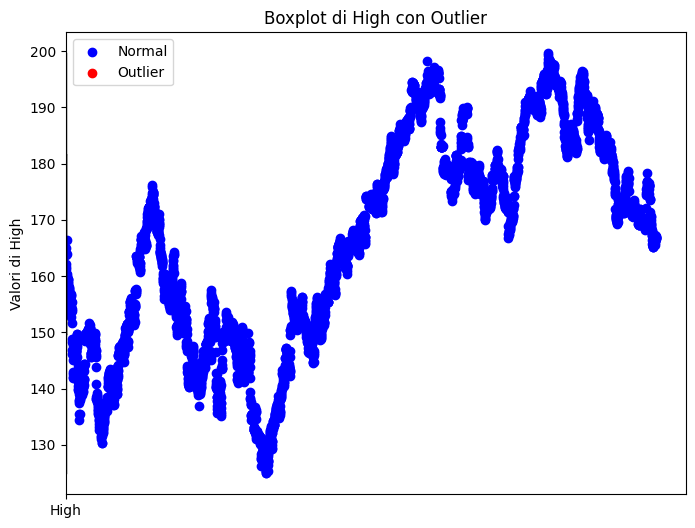

In [ ]:
# Calcola il primo e il terzo quartile per 'High'
Q1_high = df_with_missing_rows['High'].quantile(0.25)
Q3_high = df_with_missing_rows['High'].quantile(0.75)

# Calcola l'IQR per 'High'
IQR_high = Q3_high - Q1_high

# Determina i limiti per gli outlier superiori e inferiori per 'High'
upper_bound_high = Q3_high + 1.5 * IQR_high
lower_bound_high = Q1_high - 1.5 * IQR_high

# Identifica gli outlier per 'High'
outliers_high = df_with_missing_rows[(df_with_missing_rows['High'] > upper_bound_high) | (df_with_missing_rows['High'] < lower_bound_high)]
normal_values_high = df_with_missing_rows[(df_with_missing_rows['High'] <= upper_bound_high) & (df_with_missing_rows['High'] >= lower_bound_high)]

# Stampa gli outlier per 'High'
print("Outlier per 'High':")
print(outliers_high)

# Plot del boxplot per 'High' con evidenziazione degli outlier
plt.figure(figsize=(8, 6))
plt.boxplot(df_with_missing_rows['High'], showfliers=False)
plt.scatter(x=range(1, len(normal_values_high) + 1), y=normal_values_high['High'], color='blue', label='Normal')
plt.scatter(x=[len(normal_values_high) + 1]*len(outliers_high), y=outliers_high['High'], color='red', label='Outlier')
plt.title('Boxplot di High con Outlier')
plt.ylabel('Valori di High')
plt.xticks([1], ['High'])
plt.legend()

# Aggiungi annotazioni interattive al grafico
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(
    f"Indice: {sel.target.index}\nValore: {sel.target.get_ydata()[0]}"))

plt.show()

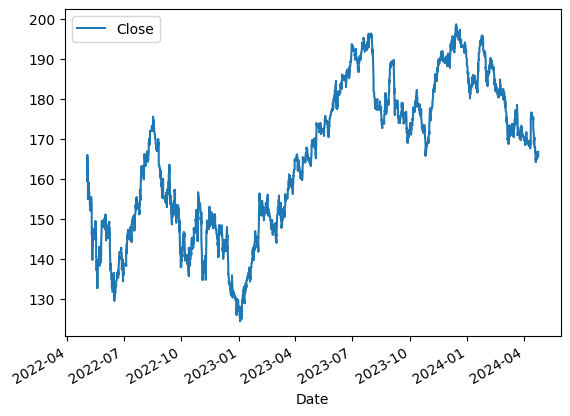

In [ ]:
df_with_missing_rows.plot(kind='line', x='Date', y='Close')
plt.show()

**LOF (Local Outlier Factor)**

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Assuming your data is stored in a DataFrame called 'df'
data = df_with_missing_rows[['Open','High','Low','Close','Volume']]

# Create an LOF object
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')

# Fit the model and predict anomalies
anomalies = lof.fit_predict(data)

# Anomalies are labeled as -1
anomaly_indices = np.where(anomalies == -1)[0]

print("Date delle anomalie:")
display(df_with_missing_rows.iloc[anomaly_indices]['Date'])

Date delle anomalie:


56     2022-05-12
945    2022-09-16
1029   2022-09-28
1036   2022-09-29
1239   2022-10-28
1288   2022-11-04
1925   2023-02-03
2562   2023-05-05
3199   2023-08-04
3437   2023-09-07
4162   2023-12-19
4691   2024-03-04
4698   2024-03-05
4705   2024-03-06
Name: Date, dtype: datetime64[ns]

In [ ]:
# Creazione della colonna 'Datetime' concatenando 'Date' e 'Time'
df_with_missing_rows['Datetime'] = pd.to_datetime(df_with_missing_rows['Date'].astype(str) + ' ' + df_with_missing_rows['Time'])

# Creazione del tracciato per i valori di 'Close' nel tempo
trace_close = go.Scatter(x=df_with_missing_rows['Datetime'], y=df_with_missing_rows['Close'], mode='lines', name='Close')

# Creazione del tracciato per i punti anomali
anomaly_dates = df_with_missing_rows.iloc[anomaly_indices]['Datetime']
anomaly_values = df_with_missing_rows.iloc[anomaly_indices]['Close']
trace_anomalies = go.Scatter(x=anomaly_dates, y=anomaly_values, mode='markers', name='Anomalie', marker=dict(color='red', size=8))

# Creazione del layout del grafico
layout = go.Layout(title='Andamento dei valori di Close nel tempo con Anomalie',
                   xaxis=dict(title='Data e Ora'),
                   yaxis=dict(title='Close'))

# Creazione della figura
fig = go.Figure(data=[trace_close, trace_anomalies], layout=layout)

# Visualizzazione del grafico
fig.show()

In [ ]:
result = adfuller(df_with_missing_rows['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6046042823702942
p-value: 0.4812802091273611


In [ ]:
fig = go.Figure()

# Aggiungi la linea per i prezzi di chiusura
fig.add_trace(go.Scatter(x=df_with_missing_rows['Date'], y=df_with_missing_rows['Close'], mode='lines', name='Close Price', line=dict(color='green')))
fig.update_layout(title='Apple Stock Prices',
                   xaxis_title='Date',
                   yaxis_title='Normalized Close Price',
                   hovermode='x unified',  # Abilita l'hover su tutto l'asse x
                   plot_bgcolor='rgba(173, 216, 230, 0.1)',
                   xaxis=dict(type='date', tickformat='%Y-%m-%d'))
fig.show()

### **Data Loading**

Load your data as described previously using pandas. For the sake of example, let’s assume you are working with one dataset

In [12]:
stock = yf.Ticker("AAPL")
df = stock.history(start="2000-01-01", end="2024-07-10", interval="1d")
#df = stock.history(start="2010-01-01", end="2024-04-24", interval="1d")
display(df)

Open    High     Low   Close     Volume  \
Date                                                                   
2000-01-03 00:00:00-05:00   $0.79   $0.85   $0.77   $0.84  535796800   
2000-01-04 00:00:00-05:00   $0.82   $0.84   $0.76   $0.77  512377600   
2000-01-05 00:00:00-05:00   $0.78   $0.83   $0.78   $0.79  778321600   
2000-01-06 00:00:00-05:00   $0.80   $0.81   $0.72   $0.72  767972800   
2000-01-07 00:00:00-05:00   $0.73   $0.76   $0.72   $0.75  460734400   
...                           ...     ...     ...     ...        ...   
2024-07-02 00:00:00-04:00 $216.15 $220.38 $215.10 $220.27   58046200   
2024-07-03 00:00:00-04:00 $220.00 $221.55 $219.03 $221.55   37369800   
2024-07-05 00:00:00-04:00 $221.65 $226.45 $221.65 $226.34   60412400   
2024-07-08 00:00:00-04:00 $227.09 $227.85 $223.25 $227.82   59085900   
2024-07-09 00:00:00-04:00 $227.93 $229.40 $226.37 $228.68   48076100   

                           Dividends  Stock Splits  
Date                                                
2000-01-03 00:00:00-05:00      $0.00         $0.00  
2000-01-04 00:00:00-05:00      $0.00         $0.00  
2000-01-05 00:00:00-05:00      $0.00         $0.00  
2000-01-06 00:00:00-05:00      $0.00         $0.00  
2000-01-07 00:00:00-05:00      $0.00         $0.00  
...                              ...           ...  
2024-07-02 00:00:00-04:00      $0.00         $0.00  
2024-07-03 00:00:00-04:00      $0.00         $0.00  
2024-07-05 00:00:00-04:00      $0.00         $0.00  
2024-07-08 00:00:00-04:00      $0.00         $0.00  
2024-07-09 00:00:00-04:00      $0.00         $0.00  

[6167 rows x 7 columns]

### **TEST con NN**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.metrics import mean_absolute_error, mean_squared_error
import math
import yfinance as yf
import plotly.express as px
from pandas.plotting import scatter_matrix

In [ ]:
data = yf.download('AAPL')
data

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.099192   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.094017   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.087116   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089273   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.091861   
...                ...         ...         ...         ...         ...   
2024-04-26  169.880005  171.339996  169.179993  169.300003  169.300003   
2024-04-29  173.369995  176.029999  173.100006  173.500000  173.500000   
2024-04-30  173.330002  174.990005  170.000000  170.330002  170.330002   
2024-05-01  169.580002  172.710007  169.110001  169.300003  169.300003   
2024-05-02  172.509995  173.419998  170.889999  173.029999  173.029999   

               Volume  
Date                   
1980-12-12  469033600  
1980-12-15  175884800  
1980-12-16  105728000  
1980-12-17   86441600  
1980-12-18   73449600  
...               ...  
2024-04-26   44838400  
2024-04-29   68169400  
2024-04-30   65934800  
2024-05-01   50383100  
2024-05-02   92880600  

[10938 rows x 6 columns]

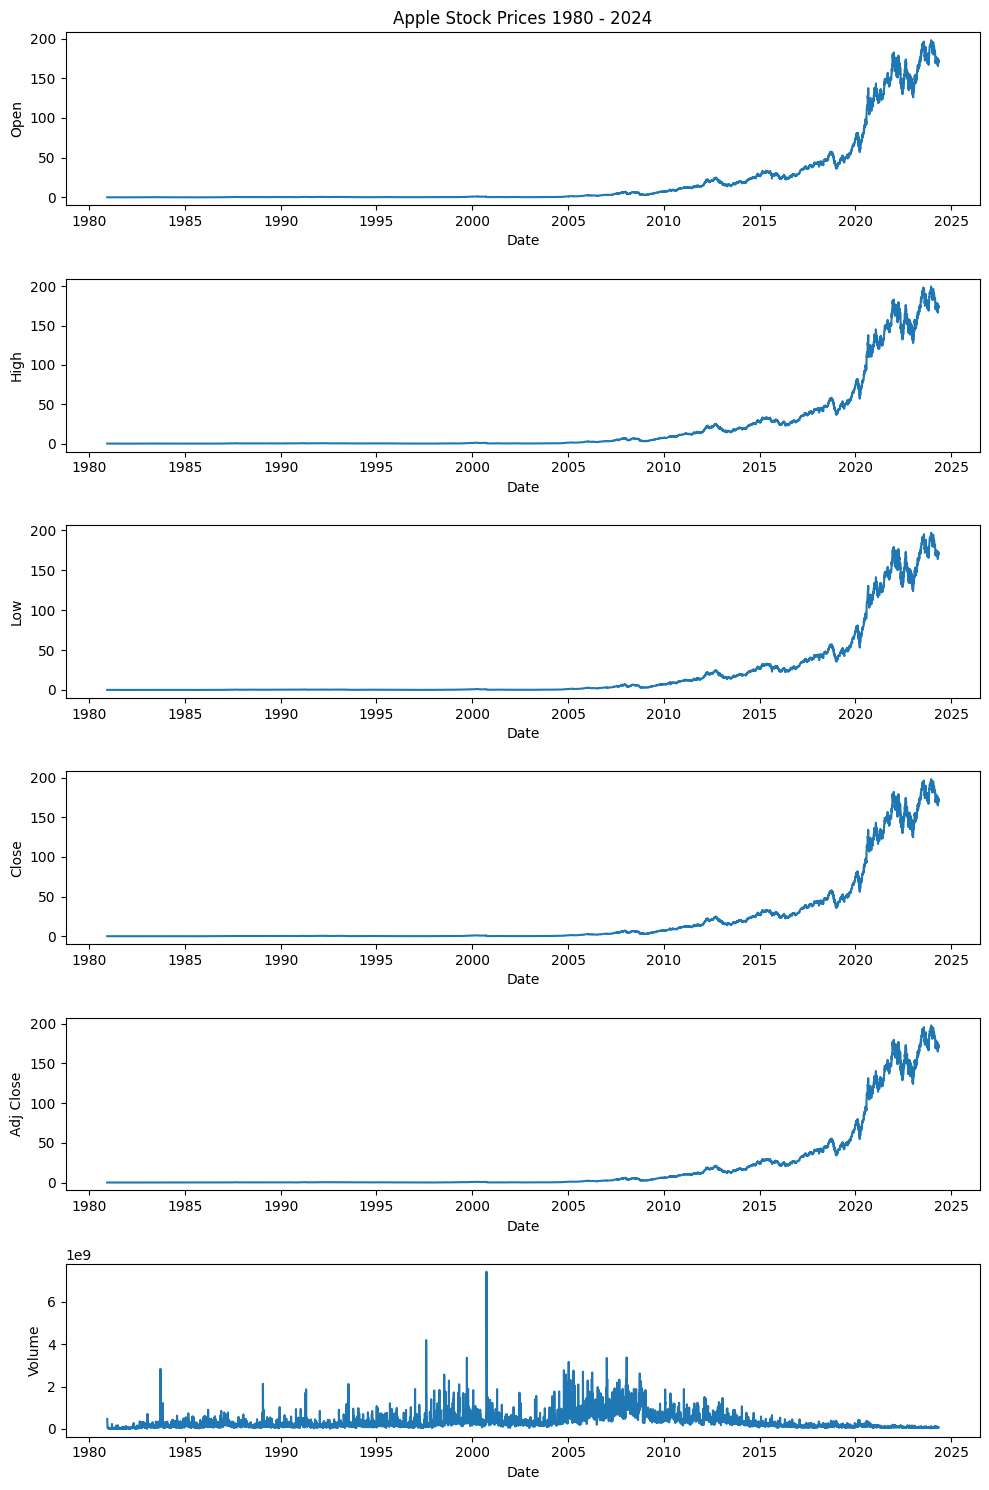

In [ ]:
def plot_col(df):
  num_cols = len(df.columns)
  fig, ax = plt.subplots(num_cols, figsize=(10, 2.5*num_cols))
  for i, column in enumerate(df.columns):
    sns.lineplot(ax=ax[i], data=df, x=df.index, y=column)
    ax[0].set_title('Apple Stock Prices 1980 - 2024')
  plt.tight_layout()
  plt.show()

plot_col(data)

Text(0.5, 1.0, 'Starbucks Closed Finance Time Series')

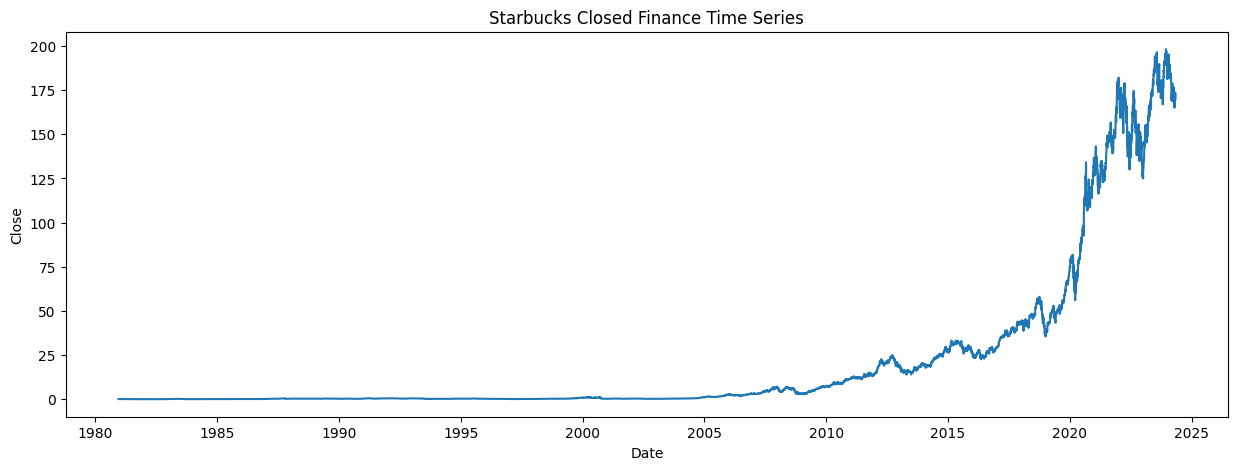

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])
plt.title('Starbucks Closed Finance Time Series')

In [ ]:
split_time = '2020-01-01'
train_data = data.loc[:split_time]
test_data = data.loc[split_time:]

In [ ]:
train_close_data = train_data['Close']
valid_close_data = test_data['Close']

print(f'Train Closed Data \n{train_close_data.head()}\n')
print(f'Validation Closed Data \n{valid_close_data.head()}\n')

Train Closed Data 
Date
1980-12-12    0.128348
1980-12-15    0.121652
1980-12-16    0.112723
1980-12-17    0.115513
1980-12-18    0.118862
Name: Close, dtype: float64

Validation Closed Data 
Date
2020-01-02    75.087502
2020-01-03    74.357498
2020-01-06    74.949997
2020-01-07    74.597504
2020-01-08    75.797501
Name: Close, dtype: float64



In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size=30
train_set = window_dataset(train_close_data, window_size)
valid_set = window_dataset(valid_close_data, window_size)

#Model building
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer= keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

#Model Compiling
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#Model Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch /30)
)

history = model.fit(train_set, epochs=200,
                    validation_data=valid_set,
                    callbacks=[early_stopping,lr_schedule])

Epoch 1/200
307/307 [==============================] - 5s 14ms/step - loss: 5.4351 - mae: 5.7841 - val_loss: 60.9850 - val_mae: 61.4850 - lr: 1.0000e-06
Epoch 2/200
307/307 [==============================] - 4s 12ms/step - loss: 0.7636 - mae: 1.0000 - val_loss: 7.1857 - val_mae: 7.6717 - lr: 1.0798e-06
Epoch 3/200
307/307 [==============================] - 2s 6ms/step - loss: 0.2304 - mae: 0.3755 - val_loss: 7.0735 - val_mae: 7.5567 - lr: 1.1659e-06
Epoch 4/200
307/307 [==============================] - 2s 6ms/step - loss: 0.2297 - mae: 0.3749 - val_loss: 7.0654 - val_mae: 7.5488 - lr: 1.2589e-06
Epoch 5/200
307/307 [==============================] - 3s 10ms/step - loss: 0.2291 - mae: 0.3740 - val_loss: 7.0659 - val_mae: 7.5498 - lr: 1.3594e-06
Epoch 6/200
307/307 [==============================] - 2s 5ms/step - loss: 0.2277 - mae: 0.3723 - val_loss: 6.9695 - val_mae: 7.4536 - lr: 1.4678e-06
Epoch 7/200
307/307 [==============================] - 2s 5ms/step - loss: 0.2284 - mae: 0.3730

65


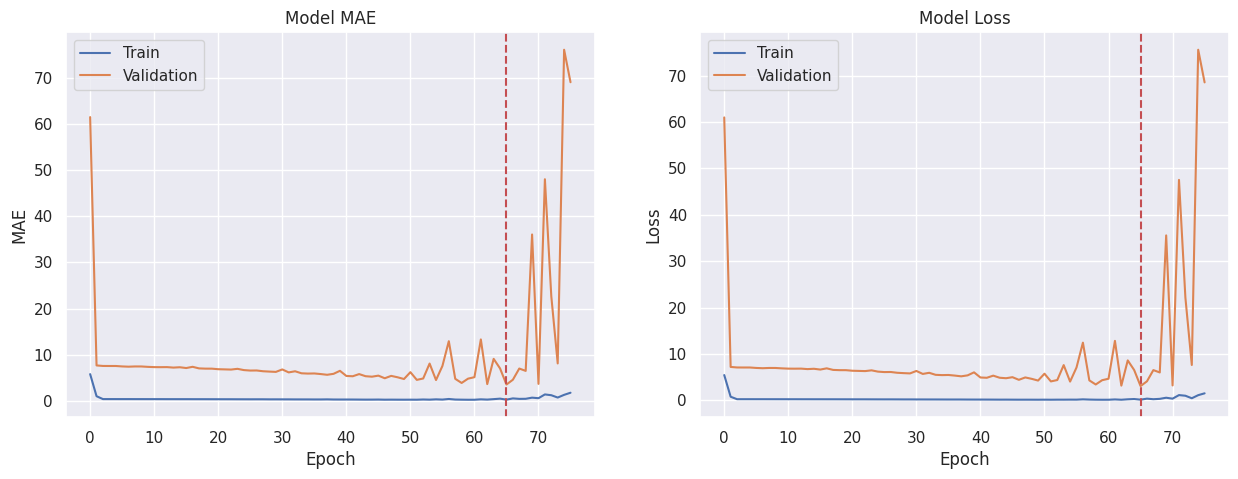

In [ ]:
def plot_history(history):
  sns.set()
  fig, axs = plt.subplots(1,2, figsize=(15,5))
  axs[0].plot(history.history['mae'])
  axs[0].plot(history.history['val_mae'])
  axs[0].set_title('Model MAE')
  axs[0].set_ylabel('MAE')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_mae'])
  axs[0].axvline(x=best_epoch, color='r', linestyle='--')

  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_loss'])
  print(best_epoch)
  axs[1].axvline(x=best_epoch, color='r', linestyle='--')

  plt.show()


plot_history(history)

The best epoch is Auto Restored by Early Stopping Callback

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
#Forecasting
forecast = model_forecast(model, valid_close_data, window_size)[:, 0]
display(forecast)

34/34 [==============================] - 0s 9ms/step


array([ 82.09894 ,  81.52338 ,  81.550705, ..., 170.7076  , 167.71056 ,
       169.27225 ], dtype=float32)

In [ ]:
forecast_df = pd.DataFrame(forecast[:-1],
                           index=valid_close_data.index[window_size:window_size+len(forecast)],
                           columns=['Forecast'])

In [ ]:
forecast_series = forecast_df['Forecast'].squeeze()
forecast_series

Date
2020-02-14     82.098938
2020-02-18     81.523376
2020-02-19     81.550705
2020-02-20     79.928253
2020-02-21     81.842468
                 ...    
2024-04-26    168.606812
2024-04-29    171.380524
2024-04-30    175.003952
2024-05-01    170.707596
2024-05-02    167.710556
Name: Forecast, Length: 1061, dtype: float32

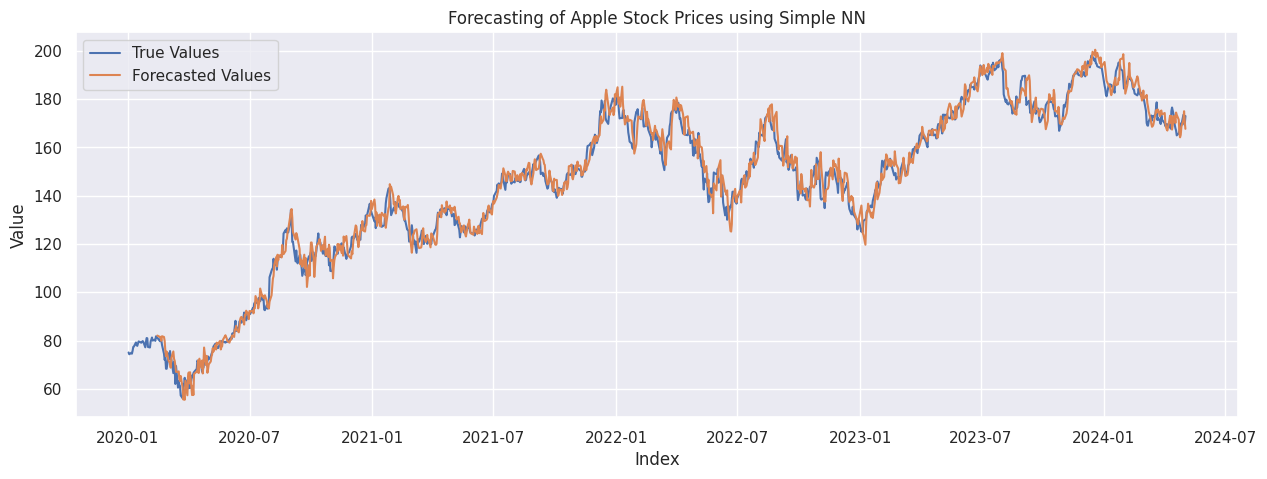

In [ ]:
def plot_predictions(y_true, y_pred):
  sns.set()
  plt.figure(figsize=(15,5))
  plt.plot(y_true, label='True Values')
  plt.plot(y_pred, label='Forecasted Values')
  plt.title('Forecasting of Apple Stock Prices using Simple NN')
  plt.ylabel('Value')
  plt.xlabel('Index')
  plt.legend(loc ='upper left')
  plt.show()

plot_predictions(valid_close_data, forecast_series)

In [ ]:
print(valid_close_data.head(5), '\n')
print(forecast_series.head(5))

Date
2020-02-14    81.237503
2020-02-18    79.750000
2020-02-19    80.904999
2020-02-20    80.074997
2020-02-21    78.262497
Name: Close, dtype: float64 

Date
2020-02-14    82.098938
2020-02-18    81.523376
2020-02-19    81.550705
2020-02-20    79.928253
2020-02-21    81.842468
Name: Forecast, dtype: float32


In [ ]:
print('Valid Data:', len(valid_close_data))
print('Forecasted Data:', len(forecast_series))

Valid Data: 1091
Forecasted Data: 1061


In [ ]:
valid_close_data = valid_close_data[window_size: ]
print('Valid Data:', len(valid_close_data))
print('Forecasted Data:', len(forecast_series))

Valid Data: 1061
Forecasted Data: 1061


In [ ]:
print(valid_close_data.head(5), '\n')
print(forecast_series.head(5))

Date
2020-02-14    81.237503
2020-02-18    79.750000
2020-02-19    80.904999
2020-02-20    80.074997
2020-02-21    78.262497
Name: Close, dtype: float64 

Date
2020-02-14    82.098938
2020-02-18    81.523376
2020-02-19    81.550705
2020-02-20    79.928253
2020-02-21    81.842468
Name: Forecast, dtype: float32


In [ ]:
print(f'Mean Squared Error: {math.sqrt(mean_squared_error(valid_close_data, forecast_series).numpy())}')
print(f'Mean Squared Error: {mean_squared_error(valid_close_data, forecast_series).numpy()}')
print(f'Mean Absolute Error: {mean_absolute_error(valid_close_data, forecast_series).numpy()}')

Mean Squared Error: 4.537882193450568
Mean Squared Error: 20.592374801635742
Mean Absolute Error: 3.533717393875122


### **TEST con GRU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data.head()

Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099192  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094017  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087116  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089273   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091861   73449600

In [ ]:
data = data.reset_index()

In [ ]:
closed_data = data[['Date','Close']]
closed_data.shape

(10938, 2)

In [ ]:
fig = px.line(closed_data, x=closed_data.Date, y=closed_data.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
closedf = closed_data[closed_data['Date'] > '2020-01-01']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  1091


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1091, 1)


In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (654, 1)
test_data:  (437, 1)


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (623, 30)
y_train:  (623,)
X_test:  (406, 30)
y_test (406,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (623, 30, 1)
X_test:  (406, 30, 1)


In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(64,return_sequences=True,input_shape=(time_step,1)))
model.add(Dropout(0.20))
model.add(GRU(64,return_sequences=True))
model.add(Dropout(0.20))
model.add(GRU(64))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            12864     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 30, 64)            24960     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [ ]:
tf.keras.backend.clear_session()

model = Sequential()

model.add(GRU(128, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1,callbacks=[early_stopping, lr_schedule])

Epoch 1/200
20/20 [==============================] - 13s 245ms/step - loss: 0.3409 - mae: 0.5395 - val_loss: 0.7001 - val_mae: 0.8256 - lr: 1.0000e-06
Epoch 2/200
20/20 [==============================] - 3s 155ms/step - loss: 0.3374 - mae: 0.5365 - val_loss: 0.6909 - val_mae: 0.8200 - lr: 1.0798e-06
Epoch 3/200
20/20 [==============================] - 3s 163ms/step - loss: 0.3317 - mae: 0.5318 - val_loss: 0.6809 - val_mae: 0.8141 - lr: 1.1659e-06
Epoch 4/200
20/20 [==============================] - 4s 184ms/step - loss: 0.3261 - mae: 0.5270 - val_loss: 0.6705 - val_mae: 0.8078 - lr: 1.2589e-06
Epoch 5/200
20/20 [==============================] - 3s 154ms/step - loss: 0.3220 - mae: 0.5235 - val_loss: 0.6592 - val_mae: 0.8009 - lr: 1.3594e-06
Epoch 6/200
20/20 [==============================] - 3s 160ms/step - loss: 0.3174 - mae: 0.5195 - val_loss: 0.6473 - val_mae: 0.7936 - lr: 1.4678e-06
Epoch 7/200
20/20 [==============================] - 4s 194ms/step - loss: 0.3088 - mae: 0.5121 - v

129


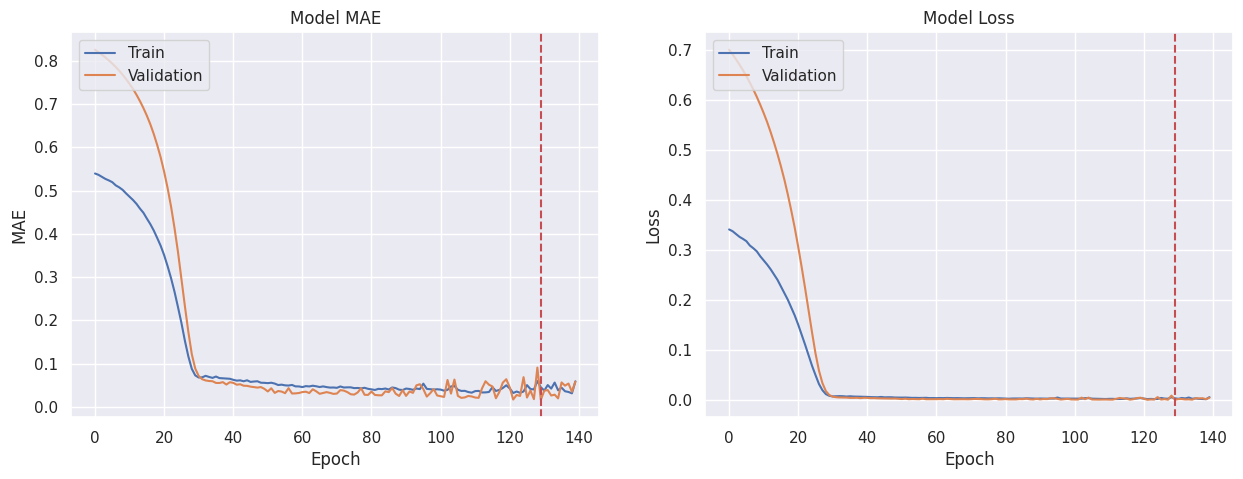

In [ ]:
def plot_history(history):
  sns.set()
  fig, axs = plt.subplots(1,2, figsize=(15,5))
  axs[0].plot(history.history['mae'])
  axs[0].plot(history.history['val_mae'])
  axs[0].set_title('Model MAE')
  axs[0].set_ylabel('MAE')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_mae'])
  axs[0].axvline(x=best_epoch, color='r', linestyle='--')

  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_loss'])
  print(best_epoch)
  axs[1].axvline(x=best_epoch, color='r', linestyle='--')

  plt.show()


plot_history(history)

In [ ]:
### Predictions and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

13/13 [==============================] - 0s 31ms/step


((623, 1), (406, 1))

In [ ]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2.9157125245560525
Train data MSE:  8.501379525853029
Train data MAE:  2.1815165218151207
-------------------------------------------------
Test data RMSE:  2.9792030612480054
Test data MSE:  8.875650880149486
Test data MAE:  2.3517264004411365


In [ ]:
# shift train predictions for plotting
from itertools import cycle

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparison between original close price vs predicted close price using GRU model',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1091, 1)
Test predicted data:  (1091, 1)


### **MIO**

In [13]:
df_new = df.copy()

# Reimposta l'indice del DataFrame in una colonna standard
df_new.reset_index(inplace=True)

# Trasformare la colonna 'Date' mantenendo solo la data
df_new['Date'] = df_new['Date'].dt.date

display(df_new)

Date    Open    High     Low   Close     Volume  Dividends  \
0     2000-01-03   $0.79   $0.85   $0.77   $0.84  535796800      $0.00   
1     2000-01-04   $0.82   $0.84   $0.76   $0.77  512377600      $0.00   
2     2000-01-05   $0.78   $0.83   $0.78   $0.79  778321600      $0.00   
3     2000-01-06   $0.80   $0.81   $0.72   $0.72  767972800      $0.00   
4     2000-01-07   $0.73   $0.76   $0.72   $0.75  460734400      $0.00   
...          ...     ...     ...     ...     ...        ...        ...   
6162  2024-07-02 $216.15 $220.38 $215.10 $220.27   58046200      $0.00   
6163  2024-07-03 $220.00 $221.55 $219.03 $221.55   37369800      $0.00   
6164  2024-07-05 $221.65 $226.45 $221.65 $226.34   60412400      $0.00   
6165  2024-07-08 $227.09 $227.85 $223.25 $227.82   59085900      $0.00   
6166  2024-07-09 $227.93 $229.40 $226.37 $228.68   48076100      $0.00   

      Stock Splits  
0            $0.00  
1            $0.00  
2            $0.00  
3            $0.00  
4            $0.00  
...            ...  
6162         $0.00  
6163         $0.00  
6164         $0.00  
6165         $0.00  
6166         $0.00  

[6167 rows x 8 columns]

In [14]:
# Conta il numero di valori pari a 0.0 nelle colonne 'Dividends' e 'Stock Splits'
num_zeros_dividends = (df_new['Dividends'] == 0.0).sum()
num_zeros_stock_splits = (df_new['Stock Splits'] == 0.0).sum()

print("Numero di valori pari a 0.0 nella colonna 'Dividends':", num_zeros_dividends)
print("Numero di valori pari a 0.0 nella colonna 'Stock Splits':", num_zeros_stock_splits)

df_new.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
display(df_new)

Numero di valori pari a 0.0 nella colonna 'Dividends': 6119
Numero di valori pari a 0.0 nella colonna 'Stock Splits': 6163


Date    Open    High     Low   Close     Volume
0     2000-01-03   $0.79   $0.85   $0.77   $0.84  535796800
1     2000-01-04   $0.82   $0.84   $0.76   $0.77  512377600
2     2000-01-05   $0.78   $0.83   $0.78   $0.79  778321600
3     2000-01-06   $0.80   $0.81   $0.72   $0.72  767972800
4     2000-01-07   $0.73   $0.76   $0.72   $0.75  460734400
...          ...     ...     ...     ...     ...        ...
6162  2024-07-02 $216.15 $220.38 $215.10 $220.27   58046200
6163  2024-07-03 $220.00 $221.55 $219.03 $221.55   37369800
6164  2024-07-05 $221.65 $226.45 $221.65 $226.34   60412400
6165  2024-07-08 $227.09 $227.85 $223.25 $227.82   59085900
6166  2024-07-09 $227.93 $229.40 $226.37 $228.68   48076100

[6167 rows x 6 columns]

In [15]:
df_base = df_new.copy()

### **FB Prophet**

In [4]:
!pip install pystan==2.19.1.1

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975242 sha256=c7893b3c1710b3b3abe79b76306b3462d96f9243cca43a37e06131cf2a9568bc
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan


In [5]:
!pip install fbprophet --quiet

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects


In [7]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import plotly.graph_objects as go
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')

pd.options.display.float_format = '${:,.2f}'.format

In [71]:
df_base.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [72]:
df_light = df_base[["Date", "Open"]]

#rename date and open
df_light.rename(columns={"Date": "ds", "Open": "y"}, inplace=True)

In [73]:
layout = {
    'title': 'Validation and Test Predictions vs Actuals',
    'xaxis_title': 'Date',
    'yaxis_title': 'Values',
    'legend_title': 'Legend',
    'xaxis': {
        'rangeselector': {
            'buttons': [
                {'count': 1, 'label': '1m', 'step': 'month', 'stepmode': 'backward'},
                {'count': 6, 'label': '6m', 'step': 'month', 'stepmode': 'backward'},
                {'count': 1, 'label': 'YTD', 'step': 'year', 'stepmode': 'todate'},
                {'count': 1, 'label': '1y', 'step': 'year', 'stepmode': 'backward'},
                {'step': 'all'}
            ]
        },
        'rangeslider': {'visible': True},
        'type': 'date'
    }
}

In [74]:
# plot the open price

x = df_light["ds"]
y = df_light["y"]

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y))

# Set title
fig.update_layout(layout)

In [75]:
# Numero di regressori da aggiungere basato su shift
n = 1

# Aggiungi regressori basati su shift
for i in range(1, n+1):
    df_light[f'y-{i}'] = df_light['y'].shift(i).fillna(method='bfill')

In [88]:
df_light.head()

ds     y   y-1
0  2000-01-03 $0.79 $0.79
1  2000-01-04 $0.82 $0.79
2  2000-01-05 $0.78 $0.82
3  2000-01-06 $0.80 $0.78
4  2000-01-07 $0.73 $0.80

In [89]:
train_size = int(len(df_light) * 0.8)
val_size = int(len(df_light) * 0.15)
test_size = len(df_light) - train_size - val_size

train = df_light[:train_size]
validation = df_light[train_size:train_size + val_size]
test = df_light[train_size + val_size:]

In [90]:
train.head()

ds     y   y-1
0  2000-01-03 $0.79 $0.79
1  2000-01-04 $0.82 $0.79
2  2000-01-05 $0.78 $0.82
3  2000-01-06 $0.80 $0.78
4  2000-01-07 $0.73 $0.80

In [94]:
# Aggiungi regressori al modello
model = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10.0)
model.add_regressor('y-1')

# Addestra il modello sui dati di training
model.fit(train)

def evaluate_forecasts(model, data, target_col):
    # Prepara il DataFrame futuro per le previsioni
    future_data = data[['ds', 'y', 'y-1']]

    # Fai le previsioni con il modello addestrato
    forecast = model.predict(future_data)

    # Calcola le metriche di errore
    y_true = data[target_col].values
    y_pred = forecast['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mae, mse, r2, forecast

# Valutazione sul set di validazione
mae_val, mse_val, r2_val, forecast_val = evaluate_forecasts(model, validation, 'y')
print(f'Mean Absolute Error on validation set: {mae_val}')
print(f'Mean Squared Error on validation set: {mse_val}')
print(f'R-squared on validation set: {r2_val}')

# Valutazione sul set di test
mae_test, mse_test, r2_test, forecast_test = evaluate_forecasts(model, test, 'y')
print(f'Mean Absolute Error on test set: {mae_test}')
print(f'Mean Squared Error on test set: {mse_test}')
print(f'R-squared on test set: {r2_test}')


# Filtra le previsioni per limitarle alla data massima disponibile nei dati
max_date = max(max(validation['ds']), max(test['ds']))
forecast_val = forecast_val[pd.to_datetime(forecast_val['ds']).dt.date <= max_date]
forecast_test = forecast_test[pd.to_datetime(forecast_test['ds']).dt.date <= max_date]

# Crea il grafico
fig = go.Figure()

# Aggiungi le previsioni del set di validazione
fig.add_trace(go.Scatter(x=forecast_val['ds'], y=forecast_val['yhat'], mode='lines', name='Validation Predictions'))
# Aggiungi i valori reali del set di validazione
fig.add_trace(go.Scatter(x=validation['ds'], y=validation['y'], mode='markers', name='Validation Actual'))

# Aggiungi le previsioni del set di test
fig.add_trace(go.Scatter(x=forecast_test['ds'], y=forecast_test['yhat'], mode='lines', name='Test Predictions'))
# Aggiungi i valori reali del set di test
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='markers', name='Test Actual'))

# Imposta titolo e etichette degli assi
fig.update_layout(
    title='Validation and Test Predictions vs Actuals',
    xaxis_title='Date',
    yaxis_title='Values',
    legend_title='Legend'
)

fig.update_layout(layout)
fig.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9762osie/jue5dd45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9762osie/uu8j73w5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51729', 'data', 'file=/tmp/tmp9762osie/jue5dd45.json', 'init=/tmp/tmp9762osie/uu8j73w5.json', 'output', 'file=/tmp/tmp9762osie/prophet_modelfqbpswtq/prophet_model-20240716175636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error on validation set: 2.032422400841349
Mean Squared Error on validation set: 7.546854143149495
R-squared on validation set: 0.9941262365101747
Mean Absolute Error on test set: 2.161049367937627
Mean Squared Error on test set: 8.54585100405463
R-squared on test set: 0.9415003843815992


### **Prova**

In [ ]:
df_prova = df.copy()
df_prova.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

# Reset index
df_prova.reset_index(inplace=True)

# Converti la colonna 'Date' in tipo datetime
df_prova['Date'] = pd.to_datetime(df_prova['Date'])

In [ ]:
from datetime import timedelta

min_date = df_prova['Date'].min()
max_date = df_prova['Date'].max()

missing_saturdays = 0
missing_sundays = 0

current_date = min_date
while current_date <= max_date:
    if current_date.weekday() == 5:  # Sabato
        if current_date not in df_prova['Date'].values:
            missing_saturdays += 1
    elif current_date.weekday() == 6:  # Domenica
        if current_date not in df_prova['Date'].values:
            missing_sundays += 1
    current_date += timedelta(days=1)

# Stampiamo il conteggio
print("Numero di sabati mancanti nel DataFrame:", missing_saturdays)
print("Numero di domeniche mancanti nel DataFrame:", missing_sundays)

Numero di sabati mancanti nel DataFrame: 2263
Numero di domeniche mancanti nel DataFrame: 2263


In [ ]:
tot = len(df_prova) - missing_saturdays - missing_sundays
print(tot)

6405


In [ ]:
# Create a new DataFrame to hold the missing rows
missing_rows = []

import numpy as np

# Iterate through the dataset
i = 0
while i < len(df_prova) - 1:
    # Check if the current day is a weekday and the next day is a weekend
    if df_prova.iloc[i]['Date'].weekday() < 4 and df_prova.iloc[i+1]['Date'].weekday() >= 4:
        # Check if the next weekday is present in the DataFrame
        if i + 2 < len(df_prova):
            # Calculate the mean values between the current weekday and the next weekday
            open_mean = (df_prova.iloc[i+1]['Open'] + df_prova.iloc[i+2]['Open']) / 2
            high_mean = (df_prova.iloc[i+1]['High'] + df_prova.iloc[i+2]['High']) / 2
            low_mean = (df_prova.iloc[i+1]['Low'] + df_prova.iloc[i+2]['Low']) / 2
            close_mean = (df_prova.iloc[i+1]['Close'] + df_prova.iloc[i+2]['Close']) / 2
            volume_mean = (df_prova.iloc[i+1]['Volume'] + df_prova.iloc[i+2]['Volume']) / 2

            # Create DataFrames for the new rows
            new_row1 = pd.DataFrame({'Date': [df_prova.iloc[i+1]['Date'] + pd.Timedelta(days=1)], 'Open': [open_mean], 'High': [high_mean], 'Low': [low_mean], 'Close': [close_mean], 'Volume': [volume_mean]})
            new_row2 = pd.DataFrame({'Date': [df_prova.iloc[i+1]['Date'] + pd.Timedelta(days=2)], 'Open': [open_mean], 'High': [high_mean], 'Low': [low_mean], 'Close': [close_mean], 'Volume': [volume_mean]})

            # Insert the new rows into the DataFrame
            df_prova = pd.concat([df_prova.iloc[:i+1], new_row1, new_row2, df_prova.iloc[i+1:]]).reset_index(drop=True)
            i += 3 # Incremento l'indice per saltare le righe appena inserite
        else:
            # If the next weekday is not present in the DataFrame, exit the loop
            break
    else:
        i += 1 # Se non è fine settimana, passa alla prossima riga

# Create a new DataFrame from the missing_rows list and concat it with the original DataFrame
missing_df = pd.DataFrame(missing_rows)
updated_df = pd.concat([df_prova, missing_df], ignore_index=True)
updated_df = updated_df.sort_values(by='Date')

In [ ]:
# Mantieni solo la parte della data senza l'orario e il fuso orario
updated_df['Date'] = updated_df['Date'].dt.date

In [ ]:
display(updated_df)

Date        Open        High         Low       Close       Volume
0      1980-12-12    0.099192    0.099623    0.099192    0.099192  469033600.0
1      1980-12-15    0.094448    0.094448    0.094017    0.094017  175884800.0
2      1980-12-16    0.087548    0.087548    0.087117    0.087117  105728000.0
3      1980-12-17    0.089273    0.089704    0.089273    0.089273   86441600.0
4      1980-12-18    0.091861    0.092292    0.091861    0.091861   73449600.0
...           ...         ...         ...         ...         ...          ...
15294  2024-04-19  166.210007  166.399994  164.080002  165.000000   67772100.0
15292  2024-04-20  165.865005  166.829994  164.425003  165.419998   57944250.0
15293  2024-04-21  165.865005  166.829994  164.425003  165.419998   57944250.0
15295  2024-04-22  165.520004  167.259995  164.770004  165.839996   48116400.0
15296  2024-04-23  165.350006  167.050003  164.919998  166.899994   49537800.0

[15297 rows x 6 columns]

In [ ]:
# Individuiamo le date mancanti nel DataFrame
missing_dates = pd.date_range(start=updated_df['Date'].min(), end=updated_df['Date'].max()).difference(updated_df['Date'])

# Iteriamo attraverso le date mancanti
for date in missing_dates:
    # Convertiamo la data mancante in un oggetto Timestamp
    date_timestamp = pd.Timestamp(date)

    # Troviamo l'indice della data precedente e successiva
    prev_date = updated_df[updated_df['Date'] < date_timestamp.date()]['Date'].max()
    next_date = updated_df[updated_df['Date'] > date_timestamp.date()]['Date'].min()

    # Selezioniamo le righe corrispondenti alla data precedente e successiva
    prev_row = updated_df[updated_df['Date'] == prev_date].iloc[0]
    next_row = updated_df[updated_df['Date'] == next_date].iloc[0]

    # Calculate mean for numeric columns (similar to Solution 1)
    numeric_cols = updated_df.select_dtypes(include=np.number).columns
    mean_row = (prev_row[numeric_cols] + next_row[numeric_cols]) / 2

    # Handle date column separately (example: set to the missing date)
    mean_row['Date'] = date_timestamp

    # Add to DataFrame
    mean_row_df = pd.DataFrame([mean_row])
    updated_df = pd.concat([updated_df, mean_row_df], ignore_index=True)

# Ordiniamo il DataFrame per data
updated_df = updated_df.sort_values(by='Date')

# Stampa del DataFrame aggiornato
print(updated_df)

TypeError: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.

In [ ]:
display(updated_df.head(15))

In [ ]:
display(updated_df.tail(15))

In [ ]:
# Creiamo un elenco di date complete dall'inizio alla fine del dataset
complete_dates = pd.date_range(start=df_prova['Date'].min(), end=df_prova['Date'].max())

# Verifichiamo se ci sono date mancanti nel DataFrame
missing_dates = complete_dates[~complete_dates.isin(df_prova['Date'])]
if len(missing_dates) > 0:
    print("Date mancanti nel dataset:")
    print(missing_dates)

# Verifichiamo se ci sono valori NaN nelle colonne numeriche
nan_values = df_prova[df_prova.isna().any(axis=1)]
if len(nan_values) > 0:
    print("Valori NaN nel dataset:")
    print(nan_values)

In [ ]:
fig = go.Figure()

# Aggiungi la linea per i prezzi di chiusura
fig.add_trace(go.Scatter(x=updated_df['Date'], y=updated_df['Close'], mode='lines', name='Close Price', line=dict(color='green')))
fig.update_layout(title='Apple Stock Prices',
                   xaxis_title='Date',
                   yaxis_title='Normalized Close Price',
                   hovermode='x unified',  # Abilita l'hover su tutto l'asse x
                   plot_bgcolor='rgba(173, 216, 230, 0.1)',
                   xaxis=dict(type='date', tickformat='%Y-%m-%d'))
fig.show()

In [ ]:
# Grafico a candela
fig = go.Figure()

# Aggiungi il grafico a candela
fig.add_trace(go.Candlestick(x=updated_df['Date'],
                open=updated_df['Open'],
                high=updated_df['High'],
                low=updated_df['Low'],
                close=updated_df['Close'], name='Candele'))

# Aggiungi il grafico del volume
fig.add_trace(go.Bar(x=updated_df['Date'], y=updated_df['Volume'], name='Volume', marker_color='rgba(0, 0, 255, 0.5)'))

# Aggiorna il layout del grafico
fig.update_layout(title='Grafico a Candela con Volume',
                   xaxis_title='Data',
                   yaxis_title='Prezzo/Volume',
                   plot_bgcolor='rgba(173, 216, 230, 0.1)')

# Mostra il grafico
fig.show()

### **Grafici**

In [ ]:
fig = go.Figure()

# Aggiungi la linea per i prezzi di chiusura
fig.add_trace(go.Scatter(x=df_new['Date'], y=df_new['Close'], mode='lines', name='Close Price', line=dict(color='green')))
fig.update_layout(title='Apple Stock Prices',
                   xaxis_title='Date',
                   yaxis_title='Normalized Close Price',
                   hovermode='x unified',  # Abilita l'hover su tutto l'asse x
                   plot_bgcolor='rgba(173, 216, 230, 0.1)',
                   xaxis=dict(type='date', tickformat='%Y-%m-%d'))
fig.show()

NameError: name 'df_new' is not defined

In [ ]:
# Grafico a candela
fig = go.Figure()

# Aggiungi il grafico a candela
fig.add_trace(go.Candlestick(x=df_new['Date'],
                open=df_new['Open'],
                high=df_new['High'],
                low=df_new['Low'],
                close=df_new['Close'], name='Candele'))

# Aggiungi il grafico del volume
fig.add_trace(go.Bar(x=df_new['Date'], y=df_new['Volume'], name='Volume', marker_color='rgba(0, 0, 255, 0.5)'))

# Aggiorna il layout del grafico
fig.update_layout(title='Grafico a Candela con Volume',
                   xaxis_title='Data',
                   yaxis_title='Prezzo/Volume',
                   plot_bgcolor='rgba(173, 216, 230, 0.1)')

# Mostra il grafico
fig.show()

NameError: name 'df_new' is not defined

### **Test dataset senza indicatori**

In [8]:
display(df_base)

Date        Open        High         Low       Close     Volume
0     2000-01-03    0.791668    0.849227    0.767607    0.844981  535796800
1     2000-01-04    0.817145    0.835073    0.763833    0.773741  512377600
2     2000-01-05    0.783176    0.834602    0.777515    0.785063  778321600
3     2000-01-06    0.801104    0.807709    0.717125    0.717125  767972800
4     2000-01-07    0.728448    0.762417    0.720900    0.751094  460734400
...          ...         ...         ...         ...         ...        ...
6162  2024-07-02  216.149994  220.380005  215.100006  220.270004   58046200
6163  2024-07-03  220.000000  221.550003  219.029999  221.550003   37369800
6164  2024-07-05  221.649994  226.449997  221.649994  226.339996   60412400
6165  2024-07-08  227.089996  227.850006  223.250000  227.820007   59085900
6166  2024-07-09  227.929993  229.399994  226.369995  228.679993   48076100

[6167 rows x 6 columns]

In [ ]:
df_test = df_base.copy()

In [ ]:
display(df_test)

Date        Open        High         Low       Close     Volume
0      1980-12-12    0.099192    0.099623    0.099192    0.099192  469033600
1      1980-12-15    0.094448    0.094448    0.094017    0.094017  175884800
2      1980-12-16    0.087548    0.087548    0.087117    0.087117  105728000
3      1980-12-17    0.089273    0.089704    0.089273    0.089273   86441600
4      1980-12-18    0.091861    0.092292    0.091861    0.091861   73449600
...           ...         ...         ...         ...         ...        ...
10926  2024-04-17  169.610001  170.649994  168.000000  168.000000   50901200
10927  2024-04-18  168.029999  168.639999  166.550003  167.039993   43122900
10928  2024-04-19  166.210007  166.399994  164.080002  165.000000   67772100
10929  2024-04-22  165.520004  167.259995  164.770004  165.839996   48116400
10930  2024-04-23  165.350006  167.050003  164.919998  166.899994   49537800

[10931 rows x 6 columns]

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

def add_weekend_rows(df):
    new_rows = []
    for index, row in df.iterrows():
        date = row['Date'].strftime('%Y-%m-%d')
        # Converte la data in un oggetto datetime
        date_obj = datetime.strptime(date, '%Y-%m-%d')

        # Se è sabato o domenica, aggiungi una riga con la media tra venerdì e lunedì
        if date_obj.weekday() == 5:  # Sabato
            friday = date_obj - timedelta(days=1)
            monday = date_obj + timedelta(days=2)
            friday_row = df[df['Date'] == friday.strftime('%Y-%m-%d')].iloc[0]
            monday_row = df[df['Date'] == monday.strftime('%Y-%m-%d')].iloc[0]
            avg_row = (friday_row + monday_row) / 2
            avg_row['Date'] = date_obj.strftime('%Y-%m-%d')
            new_rows.append(avg_row)
        elif date_obj.weekday() == 6:  # Domenica
            friday = date_obj - timedelta(days=2)
            monday = date_obj + timedelta(days=1)
            friday_row = df[df['Date'] == friday.strftime('%Y-%m-%d')].iloc[0]
            monday_row = df[df['Date'] == monday.strftime('%Y-%m-%d')].iloc[0]
            avg_row = (friday_row + monday_row) / 2
            avg_row['Date'] = date_obj.strftime('%Y-%m-%d')
            new_rows.append(avg_row)

    # Aggiungi le nuove righe al DataFrame
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    # Riordina il DataFrame per data
    df = df.sort_values(by='Date').reset_index(drop=True)

    return df

# Applica la funzione al DataFrame df_test
df_test = add_weekend_rows(df_test)
display(df_test.tail(15))

Date        Open        High         Low       Close     Volume
10916  2024-04-03  168.789993  170.679993  168.580002  169.649994   47691700
10917  2024-04-04  170.289993  171.919998  168.820007  168.820007   53704400
10918  2024-04-05  169.589996  170.389999  168.949997  169.580002   42055200
10919  2024-04-08  169.029999  169.199997  168.240005  168.449997   37425500
10920  2024-04-09  168.699997  170.080002  168.350006  169.669998   42451200
10921  2024-04-10  168.800003  169.089996  167.110001  167.779999   49709300
10922  2024-04-11  168.339996  175.460007  168.160004  175.039993   91070300
10923  2024-04-12  174.259995  178.360001  174.210007  176.550003  101593300
10924  2024-04-15  175.360001  176.630005  172.500000  172.690002   73531800
10925  2024-04-16  171.750000  173.759995  168.270004  169.380005   73711200
10926  2024-04-17  169.610001  170.649994  168.000000  168.000000   50901200
10927  2024-04-18  168.029999  168.639999  166.550003  167.039993   43122900
10928  2024-04-19  166.210007  166.399994  164.080002  165.000000   67772100
10929  2024-04-22  165.520004  167.259995  164.770004  165.839996   48116400
10930  2024-04-23  165.350006  167.050003  164.919998  166.899994   49537800

In [ ]:
#df_base['High shifted'] = df_base['Close'].shift(1)
#df_base['Low shifted'] = df_base['Close'].shift(1)
df_base['Volume shifted'] = df_base['Close'].shift(1)
df_base['Close shifted'] = df_base['Close'].shift(1)
df_base['Target Close'] = df_base['Close']


df_base.dropna(inplace=True)
df_base.drop(['High', 'Low', 'Volume', 'Date', 'Close'], axis=1, inplace=True)

display(df_base)

Open  Volume shifted  Close shifted  Target Close
1        0.094448        0.099192       0.099192      0.094017
2        0.087548        0.094017       0.094017      0.087117
3        0.089273        0.087117       0.087117      0.089273
4        0.091861        0.089273       0.089273      0.091861
5        0.097467        0.091861       0.091861      0.097467
...           ...             ...            ...           ...
10926  169.610001      169.380005     169.380005    168.000000
10927  168.029999      168.000000     168.000000    167.039993
10928  166.210007      167.039993     167.039993    165.000000
10929  165.520004      165.000000     165.000000    165.839996
10930  165.350006      165.839996     165.839996    166.899994

[10930 rows x 4 columns]

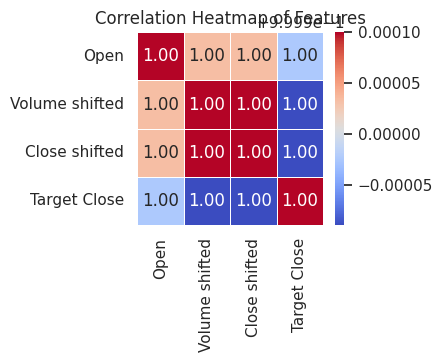

In [ ]:
# Calcola la matrice di correlazione
correlation_matrix = df_base.corr()

# Crea la heatmap della matrice di correlazione
plt.figure(figsize=(3, 2.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [ ]:
scaler = MinMaxScaler()
df_base_scaled = scaler.fit_transform(df_base)

In [ ]:
num_colonne = df_base_scaled.shape[1]
print("Il numero di colonne nel DataFrame df_new_scaled è:", num_colonne)

Il numero di colonne nel DataFrame df_new_scaled è: 4


In [ ]:
df_base.columns

Index(['Open', 'Volume shifted', 'Close shifted', 'Target Close'], dtype='object')

In [ ]:
X = []

backcandles = 30
num_col = num_colonne - 1             # numero di colonne escluse quelle target
print(df_base_scaled.shape[0])

for j in range(num_col):
  X.append([])
  for i in range(backcandles, df_base_scaled.shape[0]):
    X[j].append(df_base_scaled[i-backcandles:i, j])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(df_base_scaled[backcandles:,-1])
y = np.reshape(yi, (len(yi),1))

print(X.shape)
print(y.shape)

10930
(10900, 30, 3)
(10900, 1)


In [ ]:
# indici per lo split dei dati
test_index_start = int(len(X) * 0.85)   # Ultimo 15%
val_index_start = int(len(X) * 0.68)    # 20% del training set

X_test = X[test_index_start:]
y_test = y[test_index_start:]

X_val = X[val_index_start:test_index_start]
y_val = y[val_index_start:test_index_start]

X_train = X[:val_index_start]
y_train = y[:val_index_start]

print("Dimensioni del set di addestramento:", X_train.shape)
print("Dimensioni del set di validazione:", X_val.shape)
print("Dimensioni del set di test:", X_test.shape)

Dimensioni del set di addestramento: (7412, 30, 3)
Dimensioni del set di validazione: (1853, 30, 3)
Dimensioni del set di test: (1635, 30, 3)


In [ ]:
display(df_base)

Open  Volume shifted  Close shifted  Target Close
1        0.094448        0.099192       0.099192      0.094017
2        0.087548        0.094017       0.094017      0.087117
3        0.089273        0.087117       0.087117      0.089273
4        0.091861        0.089273       0.089273      0.091861
5        0.097467        0.091861       0.091861      0.097467
...           ...             ...            ...           ...
10926  169.610001      169.380005     169.380005    168.000000
10927  168.029999      168.000000     168.000000    167.039993
10928  166.210007      167.039993     167.039993    165.000000
10929  165.520004      165.000000     165.000000    165.839996
10930  165.350006      165.839996     165.839996    166.899994

[10930 rows x 4 columns]

In [ ]:
batch_size = 32
epochs = 20

In [ ]:
# Creazione del modello LSTM
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(backcandles, num_col)),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

# Addestramento del modello
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Predizione sui dati di test
y_pred = model.predict(X_test)

# Calcolo delle metriche
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Stampa delle metriche
print("batch_size:", batch_size, "epochs:", epochs, "backcandles:", backcandles)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R^2:", r2)

Epoch 1/20
232/232 [==============================] - 52s 185ms/step - loss: 2.9722e-04 - val_loss: 0.0089
Epoch 2/20
232/232 [==============================] - 39s 169ms/step - loss: 7.7134e-06 - val_loss: 0.0048
Epoch 3/20
232/232 [==============================] - 40s 173ms/step - loss: 6.5514e-06 - val_loss: 8.3039e-04
Epoch 4/20
232/232 [==============================] - 38s 165ms/step - loss: 6.4403e-06 - val_loss: 2.2362e-04
Epoch 5/20
232/232 [==============================] - 38s 165ms/step - loss: 6.5812e-06 - val_loss: 5.9781e-05
Epoch 6/20
232/232 [==============================] - 38s 166ms/step - loss: 6.4880e-06 - val_loss: 2.2088e-04
Epoch 7/20
232/232 [==============================] - 40s 172ms/step - loss: 5.8639e-06 - val_loss: 6.6392e-05
Epoch 8/20
232/232 [==============================] - 39s 166ms/step - loss: 5.7226e-06 - val_loss: 1.3408e-04
Epoch 9/20
232/232 [==============================] - 38s 164ms/step - loss: 4.8584e-06 - val_loss: 1.1652e-04
Epoch 10/

In [ ]:
print("Dimensioni di y_pred:", y_pred.shape)
print("Dimensioni di y_test:", y_test.shape)

Dimensioni di y_pred: (1635, 1)
Dimensioni di y_test: (1635, 1)


In [ ]:
print(X_test.shape[0])

1635


In [ ]:
import datetime

def calculate_start_date(end_date, distance):
    # Converti la stringa del giorno di fine in un oggetto datetime
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    # Sottrai i giorni lavorativi, escludendo i sabati e le domeniche
    current_date = end_date
    while distance > 0:
        current_date -= datetime.timedelta(days=1)
        if current_date.weekday() < 5:  # Se non è sabato o domenica
            distance -= 1

    return current_date.strftime('%Y-%m-%d')

# Esempio di utilizzo
end_date = '2024-04-24'
distance = X_test.shape[0]  # Numero di giorni indietro
start_date = calculate_start_date(end_date, distance)
print("Giorno di inizio:", start_date)

Giorno di inizio: 2018-01-17


In [ ]:
y_test_flat = np.ravel(y_test)
y_pred_flat = np.ravel(y_pred)
y_test_series = pd.Series(y_test_flat)
y_pred_series = pd.Series(y_pred_flat)

date_range = pd.date_range(start=start_date, end=end_date)

fig = go.Figure()
fig.add_trace(go.Scatter(x=date_range, y=y_test_series, mode='lines', name='test'))
fig.add_trace(go.Scatter(x=date_range, y=y_pred_series, mode='lines', name='pred'))

fig.update_layout(title='Confronto tra dati di test e predetti',
                   xaxis_title='Data',
                   yaxis_title='Valore',
                   hovermode='x unified')
fig.show()

### **RSI**



**RSI (Relative Strength Index):** è un indicatore utilizzato per valutare la velocità e l'intensità dei movimenti dei prezzi delle azioni. Viene calcolato confrontando i guadagni e le perdite medi delle ultime N giornate. Di solito è normalizzato tra 0 e 100.
L'RSI è utile per identificare situazioni di ipercomprato (valore dell'RSI superiore a 70) o ipervenduto (valore dell'RSI inferiore a 30), che possono indicare potenziali inversioni di tendenza.
Può essere utilizzato per confermare le tendenze dei prezzi e per identificare potenziali punti di inversione di tendenza.

In [ ]:
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_new['RSI'] = calculate_rsi(df_new['Close'])

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_new.index, y=df_new['RSI'], mode='lines', name='RSI', line=dict(color='orange')))

fig.add_shape(type="line", x0=df_new.index.min(), y0=70, x1=df_new.index.max(), y1=70, line=dict(color='red', width=1.5, dash='dash'), name='Overbought (70)')
fig.add_shape(type="line", x0=df_new.index.min(), y0=30, x1=df_new.index.max(), y1=30, line=dict(color='green', width=1.5, dash='dash'), name='Oversold (30)')

fig.update_layout(title='Relative Strength Index (RSI)',
                   xaxis_title='Date',
                   yaxis_title='RSI')

fig.show()

### **EMA**

**EMA (Exponential Moving Average):** è un tipo di media mobile che attribuisce un peso maggiore ai dati più recenti. Ciò significa che risponde più rapidamente ai cambiamenti dei prezzi rispetto alla SMA (Simple Moving Average), che dà lo stesso peso a tutti i dati.
L'EMA è particolarmente utile per evidenziare le tendenze dei prezzi e per filtrare il rumore di mercato.
È comunemente utilizzato per identificare segnali di trading, ad esempio quando il prezzo attraversa l'EMA da sotto verso sopra (indicando un potenziale segnale di acquisto) o da sopra verso sotto (indicando un potenziale segnale di vendita).

- **Death Cross:** evento che si verifica quando l'EMA più corto attraversa dall'alto verso il basso l'EMA più lungo. Questo indica un potenziale segnale di vendita perchè il prezzo recente (rappresentato dall'EMA più corto) sta diminuendo rispetto alla media a lungo termine (rappresentata dall'EMA più lungo). Questo suggerisce un indebolimento del trend rialzista precedente e può indicare il possibile inizio di una tendenza ribassista più forte.

- **Golden Cross:** evento che si verifica quando l'EMA più corto attraversa dall'alto verso il basso l'EMA più lungo. Questo indica un potenziale segnale di acquisto perchè il prezzo recente (rappresentato dall'EMA più corto) sta aumentando rispetto alla media a lungo termine (rappresentata dall'EMA più lungo). Questo suggerisce un rafforzamento del trend rialzista precedente e può indicare il possibile inizio di una tendenza rialzista più forte.

In [ ]:
df_new['EMA_short_term_A']=ta.ema(df_new['Close'], length=12)        # Short Exponential Moving Average A
df_new['EMA_short_term_B']=ta.ema(df_new['Close'], length=26)        # Short Exponential Moving Average B
df_new['EMA_long_term_A']=ta.ema(df_new['Close'], length=50)         # Long Exponential Moving Average A
df_new['EMA_long_term_B']=ta.ema(df_new['Close'], length=200)        # Long Exponential Moving Average B

In [ ]:
start_date = max(df_new['Date']) - datetime.timedelta(days=3*365)
df_new['Golden Cross_s'] = (df_new['EMA_short_term_A'] > df_new['EMA_short_term_B']) & (df_new['EMA_short_term_A'].shift(1) <= df_new['EMA_short_term_B'].shift(1))
df_new['Death Cross_s'] = (df_new['EMA_short_term_A'] < df_new['EMA_short_term_B']) & (df_new['EMA_short_term_A'].shift(1) >= df_new['EMA_short_term_B'].shift(1))


fig_short = go.Figure()

fig_short.add_trace(go.Scatter(x=df_new['Date'], y=df_new['Close'], mode='lines', name='Close', line=dict(color='blue')))
fig_short.add_trace(go.Scatter(x=df_new['Date'], y=df_new['EMA_short_term_A'], mode='lines', name='EMA_short_term_A', line=dict(color='brown', dash='dash')))
fig_short.add_trace(go.Scatter(x=df_new['Date'], y=df_new['EMA_short_term_B'], mode='lines', name='EMA_short_term_B', line=dict(color='orange', dash='dash')))

# Punti di Golden Cross e Death Cross per le medie mobili esponenziali a breve termine (short)
golden_cross_points_short = df_new[df_new['Golden Cross_s']]
death_cross_points_short = df_new[df_new['Death Cross_s']]

fig_short.add_trace(go.Scatter(x=golden_cross_points_short['Date'], y=golden_cross_points_short['Close'], mode='markers', name='Golden Cross',
                         marker=dict(color='green', symbol='triangle-up', size=14)))

fig_short.add_trace(go.Scatter(x=death_cross_points_short['Date'], y=death_cross_points_short['Close'], mode='markers', name='Death Cross',
                         marker=dict(color='red', symbol='triangle-down', size=14)))

fig_short.update_layout(title='Exponential Moving Averages - Short Term',
                   xaxis_title='Date',
                   yaxis_title='Price',
                   xaxis=dict(tickangle=45, range=[start_date, max(df_new['Date'])]),
                   hovermode='x unified',
                   plot_bgcolor='rgba(173, 216, 230, 0.1)')

fig_short.show()

In [ ]:
start_date = max(df_new['Date']) - datetime.timedelta(days=3*365)
df_new['Golden Cross_l'] = (df_new['EMA_long_term_A'] > df_new['EMA_long_term_B']) & (df_new['EMA_long_term_A'].shift(1) <= df_new['EMA_long_term_B'].shift(1))
df_new['Death Cross_l'] = (df_new['EMA_long_term_A'] < df_new['EMA_long_term_B']) & (df_new['EMA_long_term_A'].shift(1) >= df_new['EMA_long_term_B'].shift(1))

fig_long = go.Figure()

fig_long.add_trace(go.Scatter(x=df_new['Date'], y=df_new['Close'], mode='lines', name='Close', line=dict(color='blue')))
fig_long.add_trace(go.Scatter(x=df_new['Date'], y=df_new['EMA_long_term_A'], mode='lines', name='EMA_long_term_A', line=dict(color='brown', dash='dash')))
fig_long.add_trace(go.Scatter(x=df_new['Date'], y=df_new['EMA_long_term_B'], mode='lines', name='EMA_long_term_B', line=dict(color='orange', dash='dash')))

# Punti di Golden Cross e Death Cross per le medie mobili esponenziali a lungo termine (long)
golden_cross_points_long = df_new[df_new['Golden Cross_l']]
death_cross_points_long = df_new[df_new['Death Cross_l']]

fig_long.add_trace(go.Scatter(x=golden_cross_points_long['Date'], y=golden_cross_points_long['Close'], mode='markers', name='Golden Cross',
                         marker=dict(color='green', symbol='triangle-up', size=14)))

fig_long.add_trace(go.Scatter(x=death_cross_points_long['Date'], y=death_cross_points_long['Close'], mode='markers', name='Death Cross',
                         marker=dict(color='red', symbol='triangle-down', size=14)))

fig_long.update_layout(title='Exponential Moving Averages - Long Term',
                   xaxis_title='Date',
                   yaxis_title='Price',
                   xaxis=dict(tickangle=45, range=[start_date, max(df_new['Date'])]),
                   hovermode='x unified',
                   plot_bgcolor='rgba(173, 216, 230, 0.1)')

fig_long.show()

In [ ]:
display(df_new)

Date        Open        High         Low       Close     Volume  \
0     2010-01-04    6.453206    6.485559    6.421459    6.470743  493729600   
1     2010-01-05    6.488580    6.518513    6.447761    6.481928  601904800   
2     2010-01-06    6.481927    6.507628    6.372172    6.378824  552160000   
3     2010-01-07    6.402409    6.409968    6.320772    6.367033  477131200   
4     2010-01-08    6.358566    6.409967    6.321075    6.409362  447610800   
...          ...         ...         ...         ...         ...        ...   
3595  2024-04-17  169.610001  170.649994  168.000000  168.000000   50901200   
3596  2024-04-18  168.029999  168.639999  166.550003  167.039993   43122900   
3597  2024-04-19  166.210007  166.399994  164.080002  165.000000   67772100   
3598  2024-04-22  165.520004  167.259995  164.770004  165.839996   48116400   
3599  2024-04-23  165.350006  167.050003  164.919998  166.899994   49537800   

            RSI  EMA_short_term_A  EMA_short_term_B  EMA_long_term_A  \
0           NaN               NaN               NaN              NaN   
1           NaN               NaN               NaN              NaN   
2           NaN               NaN               NaN              NaN   
3           NaN               NaN               NaN              NaN   
4           NaN               NaN               NaN              NaN   
...         ...               ...               ...              ...   
3595  40.661275        170.896341        172.255047       175.328844   
3596  41.944842        170.303057        171.868747       175.003791   
3597  41.065720        169.487202        171.359951       174.611486   
3598  44.604314        168.926094        170.951065       174.267506   
3599  45.098037        168.614386        170.650986       173.978584   

      EMA_long_term_B  Golden Cross_s  Death Cross_s  Golden Cross_l  \
0                 NaN           False          False           False   
1                 NaN           False          False           False   
2                 NaN           False          False           False   
3                 NaN           False          False           False   
4                 NaN           False          False           False   
...               ...             ...            ...             ...   
3595       177.938141           False          False           False   
3596       177.829702           False          False           False   
3597       177.702043           False          False           False   
3598       177.584013           False          False           False   
3599       177.477704           False          False           False   

      Death Cross_l  
0             False  
1             False  
2             False  
3             False  
4             False  
...             ...  
3595          False  
3596          False  
3597          False  
3598          False  
3599          False  

[3600 rows x 15 columns]

In [ ]:
num_golden_cross_s = df_new[df_new['Golden Cross_s'] == True].shape[0]
num_death_cross_s = df_new[df_new['Death Cross_s'] == True].shape[0]
num_golden_cross_l = df_new[df_new['Golden Cross_l'] == True].shape[0]
num_death_cross_l = df_new[df_new['Death Cross_l'] == True].shape[0]

print("GoldenCross short a True:", num_golden_cross_s)
print("DeathCross short a True:", num_death_cross_s)
print("GoldenCross long a True:", num_golden_cross_l)
print("DeathCross long a True:", num_death_cross_l)

GoldenCross short a True: 59
DeathCross short a True: 59
GoldenCross long a True: 6
DeathCross long a True: 7


### **Bollinger Band**

In [ ]:
window_size = 20
num_std = 2

# Calcolo la media mobile e lo scarto standard
rolling_mean = df_new['Close'].rolling(window=window_size).mean()
rolling_std = df_new['Close'].rolling(window=window_size).std()

# Calcolo delle Bollinger Bands
upper_band = rolling_mean + (rolling_std * num_std)
lower_band = rolling_mean - (rolling_std * num_std)

# Aggiunta delle colonne al DataFrame
df_new['Upper Bollinger Band'] = upper_band
df_new['Lower Bollinger Band'] = lower_band

### **Salvataggio dataset con RSI e EMA**

In [ ]:
df_full = df_new.copy()

In [ ]:
display(df_full)

Date        Open        High         Low       Close     Volume  \
0     2010-01-04    6.453206    6.485559    6.421459    6.470743  493729600   
1     2010-01-05    6.488580    6.518513    6.447761    6.481928  601904800   
2     2010-01-06    6.481927    6.507628    6.372172    6.378824  552160000   
3     2010-01-07    6.402409    6.409968    6.320772    6.367033  477131200   
4     2010-01-08    6.358566    6.409967    6.321075    6.409362  447610800   
...          ...         ...         ...         ...         ...        ...   
3595  2024-04-17  169.610001  170.649994  168.000000  168.000000   50901200   
3596  2024-04-18  168.029999  168.639999  166.550003  167.039993   43122900   
3597  2024-04-19  166.210007  166.399994  164.080002  165.000000   67772100   
3598  2024-04-22  165.520004  167.259995  164.770004  165.839996   48116400   
3599  2024-04-23  165.350006  167.050003  164.919998  166.899994   49537800   

            RSI  EMA_short_term_A  EMA_short_term_B  EMA_long_term_A  \
0           NaN               NaN               NaN              NaN   
1           NaN               NaN               NaN              NaN   
2           NaN               NaN               NaN              NaN   
3           NaN               NaN               NaN              NaN   
4           NaN               NaN               NaN              NaN   
...         ...               ...               ...              ...   
3595  40.661275        170.896341        172.255047       175.328844   
3596  41.944842        170.303057        171.868747       175.003791   
3597  41.065720        169.487202        171.359951       174.611486   
3598  44.604314        168.926094        170.951065       174.267506   
3599  45.098037        168.614386        170.650986       173.978584   

      EMA_long_term_B  Golden Cross_s  Death Cross_s  Golden Cross_l  \
0                 NaN           False          False           False   
1                 NaN           False          False           False   
2                 NaN           False          False           False   
3                 NaN           False          False           False   
4                 NaN           False          False           False   
...               ...             ...            ...             ...   
3595       177.938141           False          False           False   
3596       177.829702           False          False           False   
3597       177.702043           False          False           False   
3598       177.584013           False          False           False   
3599       177.477704           False          False           False   

      Death Cross_l  Upper Bollinger Band  Lower Bollinger Band  
0             False                   NaN                   NaN  
1             False                   NaN                   NaN  
2             False                   NaN                   NaN  
3             False                   NaN                   NaN  
4             False                   NaN                   NaN  
...             ...                   ...                   ...  
3595          False            176.948702            165.266297  
3596          False            175.439111            165.612887  
3597          False            175.683845            164.731155  
3598          False            175.600859            164.170140  
3599          False            175.534512            163.841485  

[3600 rows x 17 columns]

### **Close target e shift**

**Definizione del target:**

- Viene calcolata la differenza tra il prezzo di chiusura aggiustato (Adj Close) e il prezzo di apertura (Open) per creare una feature denominata 'Target' che viene spostata di una riga sopra, in modo che per effettuare il task di predizione del prezzo delle azioni del giorno successivo si abbiano solo le informazioni disponibili fino al giorno precedente.
- Viene creata una feature binaria 'TargetClass' che indica se il prezzo di chiusura successivo è superiore al prezzo di apertura corrente (1) o inferiore (0).
- Viene creata una feature 'TargetNextClose' che rappresenta il prezzo di chiusura spostato anche esso di una riga in avanti.


Bisogna trainare il modello in modo che sia in grado di predire la colonna **TargetNextClose**

In [ ]:
df_new['Close shifted'] = df_new['Close'].shift(1)
df_new['Target Close'] = df_new['Close']

display(df_new)

Date        Open        High         Low       Close     Volume  \
0     2010-01-04    6.453206    6.485559    6.421459    6.470743  493729600   
1     2010-01-05    6.488580    6.518513    6.447761    6.481928  601904800   
2     2010-01-06    6.481927    6.507628    6.372172    6.378824  552160000   
3     2010-01-07    6.402409    6.409968    6.320772    6.367033  477131200   
4     2010-01-08    6.358566    6.409967    6.321075    6.409362  447610800   
...          ...         ...         ...         ...         ...        ...   
3595  2024-04-17  169.610001  170.649994  168.000000  168.000000   50901200   
3596  2024-04-18  168.029999  168.639999  166.550003  167.039993   43122900   
3597  2024-04-19  166.210007  166.399994  164.080002  165.000000   67772100   
3598  2024-04-22  165.520004  167.259995  164.770004  165.839996   48116400   
3599  2024-04-23  165.350006  167.050003  164.919998  166.899994   49537800   

            RSI  EMA_short_term_A  EMA_short_term_B  EMA_long_term_A  \
0           NaN               NaN               NaN              NaN   
1           NaN               NaN               NaN              NaN   
2           NaN               NaN               NaN              NaN   
3           NaN               NaN               NaN              NaN   
4           NaN               NaN               NaN              NaN   
...         ...               ...               ...              ...   
3595  40.661275        170.896341        172.255047       175.328844   
3596  41.944842        170.303057        171.868747       175.003791   
3597  41.065720        169.487202        171.359951       174.611486   
3598  44.604314        168.926094        170.951065       174.267506   
3599  45.098037        168.614386        170.650986       173.978584   

      EMA_long_term_B  Golden Cross_s  Death Cross_s  Golden Cross_l  \
0                 NaN           False          False           False   
1                 NaN           False          False           False   
2                 NaN           False          False           False   
3                 NaN           False          False           False   
4                 NaN           False          False           False   
...               ...             ...            ...             ...   
3595       177.938141           False          False           False   
3596       177.829702           False          False           False   
3597       177.702043           False          False           False   
3598       177.584013           False          False           False   
3599       177.477704           False          False           False   

      Death Cross_l  Upper Bollinger Band  Lower Bollinger Band  \
0             False                   NaN                   NaN   
1             False                   NaN                   NaN   
2             False                   NaN                   NaN   
3             False                   NaN                   NaN   
4             False                   NaN                   NaN   
...             ...                   ...                   ...   
3595          False            176.948702            165.266297   
3596          False            175.439111            165.612887   
3597          False            175.683845            164.731155   
3598          False            175.600859            164.170140   
3599          False            175.534512            163.841485   

      Close shifted  Target Close  
0               NaN      6.470743  
1          6.470743      6.481928  
2          6.481928      6.378824  
3          6.378824      6.367033  
4          6.367033      6.409362  
...             ...           ...  
3595     169.380005    168.000000  
3596     168.000000    167.039993  
3597     167.039993    165.000000  
3598     165.000000    165.839996  
3599     165.839996    166.899994  

[3600 rows x 19 columns]

In [ ]:
nan_counts = df_new.isna().sum()
print(nan_counts)

Date                      0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
RSI                      13
EMA_short_term_A         11
EMA_short_term_B         25
EMA_long_term_A          49
EMA_long_term_B         199
Golden Cross_s            0
Death Cross_s             0
Golden Cross_l            0
Death Cross_l             0
Upper Bollinger Band     19
Lower Bollinger Band     19
Close shifted             1
Target Close              0
dtype: int64


In [ ]:
df_new.dropna(inplace=True)
df_new.drop(['Close', 'Date', 'Golden Cross_l', 'Golden Cross_s', 'Death Cross_l', 'Death Cross_s'], axis=1, inplace=True)

In [ ]:
display(df_new)

Open        High         Low      Volume        RSI  \
199     9.629162    9.645186    9.502776  1093010800  82.036953   
200     9.173513    9.487056    9.071316  1232784000  69.540678   
201     9.342831    9.501568    9.278430   721624400  74.787218   
202     9.444422    9.516383    9.276312   551460000  75.092953   
203     9.344948    9.374277    9.261196   372778000  77.737357   
...          ...         ...         ...         ...        ...   
3595  169.610001  170.649994  168.000000    50901200  40.661275   
3596  168.029999  168.639999  166.550003    43122900  41.944842   
3597  166.210007  166.399994  164.080002    67772100  41.065720   
3598  165.520004  167.259995  164.770004    48116400  44.604314   
3599  165.350006  167.050003  164.919998    49537800  45.098037   

      EMA_short_term_A  EMA_short_term_B  EMA_long_term_A  EMA_long_term_B  \
199           9.053629          8.729913         8.406321         7.422305   
200           9.100401          8.776412         8.443628         7.441563   
201           9.144815          8.821795         8.480705         7.460941   
202           9.177698          8.861555         8.515130         7.479823   
203           9.195986          8.893779         8.545775         7.497900   
...                ...               ...              ...              ...   
3595        170.896341        172.255047       175.328844       177.938141   
3596        170.303057        171.868747       175.003791       177.829702   
3597        169.487202        171.359951       174.611486       177.702043   
3598        168.926094        170.951065       174.267506       177.584013   
3599        168.614386        170.650986       173.978584       177.477704   

      Upper Bollinger Band  Lower Bollinger Band  Close shifted  Target Close  
199               9.457251              8.241425       9.516378      9.614951  
200               9.522503              8.253939       9.614951      9.357648  
201               9.588018              8.257301       9.357648      9.389091  
202               9.640286              8.267318       9.389091      9.358553  
203               9.677411              8.276001       9.358553      9.296572  
...                    ...                   ...            ...           ...  
3595            176.948702            165.266297     169.380005    168.000000  
3596            175.439111            165.612887     168.000000    167.039993  
3597            175.683845            164.731155     167.039993    165.000000  
3598            175.600859            164.170140     165.000000    165.839996  
3599            175.534512            163.841485     165.839996    166.899994  

[3401 rows x 13 columns]

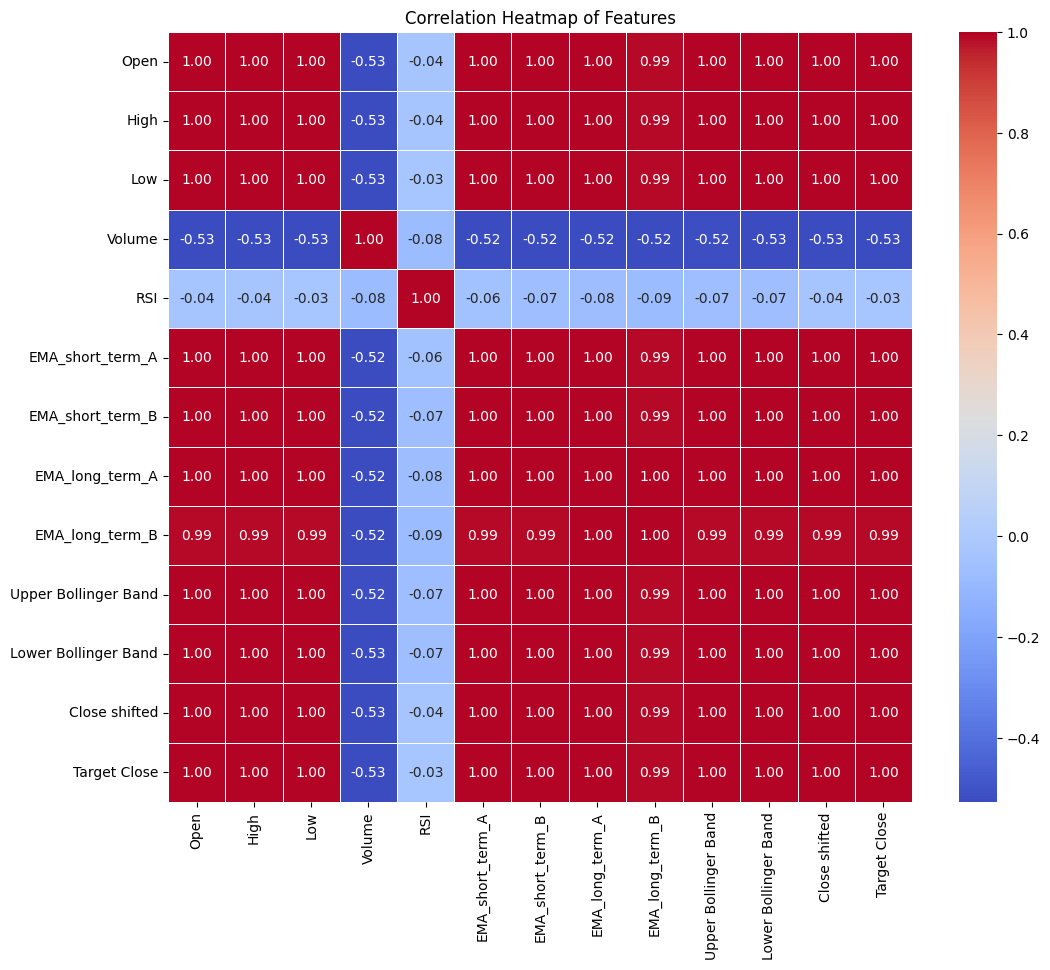

In [ ]:
# Calcola la matrice di correlazione
correlation_matrix = df_new.corr()

# Crea la heatmap della matrice di correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

### **Con indicatori RSI e EMA**

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
df_new_scaled = sc.fit_transform(df_new)

In [ ]:
num_colonne = df_new_scaled.shape[1]
print("Il numero di colonne nel DataFrame df_new_scaled è:", num_colonne)

Il numero di colonne nel DataFrame df_new_scaled è: 13


In [ ]:
df_new.columns

Index(['Open', 'High', 'Low', 'Volume', 'RSI', 'EMA_short_term_A',
       'EMA_short_term_B', 'EMA_long_term_A', 'EMA_long_term_B',
       'Upper Bollinger Band', 'Lower Bollinger Band', 'Close shifted',
       'Target Close'],
      dtype='object')

In [ ]:
X = []

backcandles = 10
num_col = num_colonne - 1                         # numero di colonne escluse quelle target
print(df_new_scaled.shape[0])

for j in range(num_col):
  X.append([])
  for i in range(backcandles, df_new_scaled.shape[0]):
    X[j].append(df_new_scaled[i-backcandles:i, j])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(df_new_scaled[backcandles:,-1])
y = np.reshape(yi, (len(yi),1))

print(X.shape)
print(y.shape)

3401
(3391, 10, 12)
(3391, 1)


In [ ]:
# Calcola gli indici per lo split dei dati
test_index_start = int(len(X) * 0.85)  # Ultimo 15%
val_index_start = int(len(X) * 0.68)    # Un 20% del training set

# Estrapola i dati per i set di test, validazione e addestramento
X_test = X[test_index_start:]
y_test = y[test_index_start:]

X_val = X[val_index_start:test_index_start]
y_val = y[val_index_start:test_index_start]

X_train = X[:val_index_start]
y_train = y[:val_index_start]

print("Dimensioni del set di addestramento:", X_train.shape)
print("Dimensioni del set di validazione:", X_val.shape)
print("Dimensioni del set di test:", X_test.shape)

Dimensioni del set di addestramento: (2305, 10, 12)
Dimensioni del set di validazione: (577, 10, 12)
Dimensioni del set di test: (509, 10, 12)


In [ ]:
batch_size = 16
epochs = 100

In [ ]:
# Classe per il modello LSTM
class LstmRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, validation_data=None):
        self.model = None
        self.validation_data = validation_data

    def fit(self, X, y):
        # Creazione del modello LSTM
        self.model = Sequential()
        self.model.add(LSTM(128, return_sequences=True, input_shape=(backcandles, num_col)))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(64, return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(32))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(16, activation='relu'))
        self.model.add(Dense(1, activation='linear'))

        self.model.compile(optimizer='adam', loss='mse')

        if self.validation_data:
            self.model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=self.validation_data)
        else:
            self.model.fit(X, y, batch_size=batch_size, epochs=epochs)

        return self

    def predict(self, X):
        # Predizione
        return self.model.predict(X)

# Creazione dell'oggetto del modello
lstm_model = LstmRegressor(validation_data=(X_val, y_val))

# Addestramento del modello
lstm_model.fit(X_train, y_train)

# Predizione sui dati di test
y_pred_test = lstm_model.predict(X_test)

# Predizione sui dati di validazione
y_pred_val = lstm_model.predict(X_val)

# Calcolo delle metriche sul test set
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Calcolo delle metriche sul validation set
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Stampa delle metriche
print("batch_size:", batch_size, "epochs:", epochs, "backcandles:", backcandles)
print("\nTest set:")
print("MSE:", mse_test)
print("RMSE:", rmse_test)
print("MAE:", mae_test)
print("R^2:", r2_test)
print("\nValidation set:")
print("MSE:", mse_val)
print("RMSE:", rmse_val)
print("MAE:", mae_val)
print("R^2:", r2_val)

Epoch 1/100
145/145 [==============================] - 10s 33ms/step - loss: 6.4636e-04 - val_loss: 0.0096
Epoch 2/100
145/145 [==============================] - 3s 23ms/step - loss: 1.9482e-04 - val_loss: 0.0130
Epoch 3/100
145/145 [==============================] - 3s 20ms/step - loss: 2.0285e-04 - val_loss: 0.0076
Epoch 4/100
145/145 [==============================] - 3s 20ms/step - loss: 1.6758e-04 - val_loss: 0.0094
Epoch 5/100
145/145 [==============================] - 4s 25ms/step - loss: 1.3667e-04 - val_loss: 0.0168
Epoch 6/100
145/145 [==============================] - 3s 22ms/step - loss: 1.1254e-04 - val_loss: 0.0063
Epoch 7/100
145/145 [==============================] - 3s 20ms/step - loss: 1.1535e-04 - val_loss: 0.0145
Epoch 8/100
145/145 [==============================] - 3s 20ms/step - loss: 1.3243e-04 - val_loss: 0.0030
Epoch 9/100
145/145 [==============================] - 4s 25ms/step - loss: 1.1899e-04 - val_loss: 0.0123
Epoch 10/100
145/145 [=======================

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import datetime

# Crea un oggetto figura con due sottoplot
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# Genera una sequenza di date nel formato specificato
start_date = datetime.datetime(2019, 12, 2)
end_date = datetime.datetime(2024, 4, 24)

# Calcola il numero di punti dati
num_points = len(y_test)

# Calcola l'intervallo di date per il numero di punti dati
date_range = [start_date + datetime.timedelta(days=i) for i in range(num_points)]

# Aggiungi i valori reali al primo sottoplot
fig.add_trace(go.Scatter(x=date_range, y=y_test.flatten(), mode='lines', name='Valore reale'), row=1, col=1)

# Aggiungi le predizioni al secondo sottoplot
fig.add_trace(go.Scatter(x=date_range, y=y_pred.flatten(), mode='lines', name='Predizione'), row=2, col=1)

# Imposta il layout del grafico
fig.update_layout(title='Confronto tra valore reale e predizione',
                  xaxis=dict(title='Data'),
                  yaxis=dict(title='Valore'),
                  showlegend=True)

# Aggiungi la funzione di aggiornamento per mostrare i valori al passaggio del cursore
fig.update_layout(hovermode='x unified')

# Mostra il grafico
fig.show()


In [ ]:
y_test_flat = np.ravel(y_test)
y_pred_flat = np.ravel(y_pred)
y_test_series = pd.Series(y_test_flat)
y_pred_series = pd.Series(y_pred_flat)

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_series.index, y=y_test_series, mode='lines', name='test', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=y_test_series.index, y=y_pred_series, mode='lines', name='pred', line=dict(color='green')))

fig.update_layout(title='Confronto tra dati di test e predetti',
                   xaxis_title='Data',
                   yaxis_title='Valore',
                   hovermode='x unified')
fig.show()

## **INDICATORI**

**MOVING AVERAGE (SMA)**

The MA – or ‘simple moving average’ (SMA) – is an indicator used to identify the direction of a current price trend, without the interference of shorter-term price spikes. The MA indicator combines price points of a financial instrument over a specified time frame and divides it by the number of data points to present a single trend line.

The data used depends on the length of the MA. For example, a 200-day MA requires 200 days of data. By using the MA indicator, you can study levels of support and resistance and see previous price action (the history of the market). This means you can also determine possible future patterns.



In [ ]:
# Calculate Simple Moving Average
df_full['SMA'] = df_full['Close'].rolling(window=200).mean()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_full.index, y=df_full['Close'], mode='lines', name='Close'))
fig.add_trace(go.Scatter(x=df_full.index, y=df_full['SMA'], mode='lines', name='200-day SMA'))

fig.update_layout(title='200-day Simple Moving Average',
                   xaxis_title='Date',
                   yaxis_title='Price',
                   hovermode='x unified')

fig.show()

In [ ]:
df_full['EMA_short_term_A']=ta.ema(df_full['Close'], length=12)        # Short Exponential Moving Average A
df_full['EMA_short_term_B']=ta.ema(df_full['Close'], length=26)        # Short Exponential Moving Average B
df_full['EMA_long_term_A']=ta.ema(df_full['Close'], length=50)         # Long Exponential Moving Average A
df_full['EMA_long_term_B']=ta.ema(df_full['Close'], length=200)        # Long Exponential Moving Average B

In [ ]:
df_full['Close_shifted'] = df_full['Close'].shift(periods=1)

In [ ]:
df_full.drop(['EMA_long', 'EMA_short'], axis=1, inplace=True)

In [ ]:
df_full['Close_lagged'] = df_full['Close'].shift(1)  # Create the lagged Close feature

In [ ]:
display(df_full)

Date        Open        High         Low       Close     Volume  \
0      1980-12-12    0.099192    0.099623    0.099192    0.099192  469033600   
1      1980-12-15    0.094448    0.094448    0.094017    0.094017  175884800   
2      1980-12-16    0.087548    0.087548    0.087117    0.087117  105728000   
3      1980-12-17    0.089273    0.089704    0.089273    0.089273   86441600   
4      1980-12-18    0.091861    0.092292    0.091861    0.091861   73449600   
...           ...         ...         ...         ...         ...        ...   
10926  2024-04-17  169.610001  170.649994  168.000000  168.000000   50901200   
10927  2024-04-18  168.029999  168.639999  166.550003  167.039993   43122900   
10928  2024-04-19  166.210007  166.399994  164.080002  165.000000   67772100   
10929  2024-04-22  165.520004  167.259995  164.770004  165.839996   48116400   
10930  2024-04-23  165.350006  167.050003  164.919998  166.899994   49537800   

             RSI  Golden Cross  Death Cross         SMA  EMA_short_term_A  \
0            NaN         False        False         NaN               NaN   
1            NaN         False        False         NaN               NaN   
2            NaN         False        False         NaN               NaN   
3            NaN         False        False         NaN               NaN   
4            NaN         False        False         NaN               NaN   
...          ...           ...          ...         ...               ...   
10926  42.212361         False        False  182.133202        170.896341   
10927  40.897530         False        False  182.009887        170.303057   
10928  38.189275         False        False  181.882000        169.487202   
10929  39.943810         False        False  181.755923        168.926094   
10930  42.163494         False        False  181.640773        168.614386   

       EMA_short_term_B  EMA_long_term_A  EMA_long_term_B  Close_lagged  
0                   NaN              NaN              NaN           NaN  
1                   NaN              NaN              NaN      0.099192  
2                   NaN              NaN              NaN      0.094017  
3                   NaN              NaN              NaN      0.087117  
4                   NaN              NaN              NaN      0.089273  
...                 ...              ...              ...           ...  
10926        172.255047       175.328844       177.938141    169.380005  
10927        171.868747       175.003791       177.829701    168.000000  
10928        171.359951       174.611486       177.702043    167.039993  
10929        170.951065       174.267506       177.584012    165.000000  
10930        170.650986       173.978584       177.477704    165.839996  

[10931 rows x 15 columns]

In [ ]:
df_full.dropna(inplace=True)

In [ ]:
df_full.drop(columns=['Date'], inplace=True)
print(df_full.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'Golden Cross',
       'Death Cross', 'SMA', 'EMA_short_term_A', 'EMA_short_term_B',
       'EMA_long_term_A', 'EMA_long_term_B', 'Close_lagged'],
      dtype='object')


In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
df_full_scaled = sc.fit_transform(df_full)
print(df_full_scaled)

[[5.67093495e-05 5.84182343e-05 5.91951730e-05 ... 1.35258821e-04
  1.92741060e-04 5.66835524e-05]
 [6.97953353e-05 7.13993143e-05 7.23488984e-05 ... 1.31239127e-04
  1.90583152e-04 5.88634413e-05]
 [7.19761633e-05 7.35626290e-05 7.45410155e-05 ... 1.27466736e-04
  1.88470510e-04 7.19434527e-05]
 ...
 [8.40399748e-01 8.34615635e-01 8.33924178e-01 ... 9.25630335e-01
  9.85121032e-01 8.44213925e-01]
 [8.36910116e-01 8.38930152e-01 8.37431874e-01 ... 9.23806388e-01
  9.84466503e-01 8.33901532e-01]
 [8.36050364e-01 8.37876651e-01 8.38194383e-01 ... 9.22274384e-01
  9.83876976e-01 8.38147807e-01]]


In [ ]:
close_column_index = df_full.columns.get_loc('Close')
print(close_column_index)

3


In [ ]:
num_colonne = df_full_scaled.shape[1]
print("Il numero di colonne nel DataFrame df_new_scaled è:", num_colonne)
col_no_target = (num_colonne - 1)

Il numero di colonne nel DataFrame df_new_scaled è: 14


In [ ]:
X = []

backcandles = 30
print(df_full_scaled.shape[0])

for j in range(col_no_target):      # numero di colonne escluse quelle target
  X.append([])
  for i in range(backcandles, df_full_scaled.shape[0]):
    X[j].append(df_full_scaled[i-backcandles:i, j])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(df_full_scaled[backcandles:, close_column_index])
y = np.reshape(yi, (len(yi),1))

print(X.shape)
print(y.shape)

10732
(10702, 30, 13)
(10702, 1)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print("Dimensioni del set di addestramento:", X_train.shape)
print("Dimensioni del set di validazione:", X_val.shape)
print("Dimensioni del set di test:", X_test.shape)

Dimensioni del set di addestramento: (7276, 30, 13)
Dimensioni del set di validazione: (1820, 30, 13)
Dimensioni del set di test: (1606, 30, 13)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Activation
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

# Classe per il modello LSTM
class LstmRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = None

    def fit(self, X, y):
        # Creazione del modello LSTM
        self.model = Sequential()
        self.model.add(LSTM(256, return_sequences=True, input_shape=(backcandles, col_no_target)))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(128, return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(32))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='linear'))

        # Compilazione del modello con l'ottimizzatore Adam e il tasso di apprendimento di default (0.001)
        optimizer = Adam()
        self.model.compile(optimizer=optimizer, loss='mse')

        # Addestramento del modello per un numero maggiore di epoche (100)
        self.model.fit(X, y, batch_size=32, epochs=10)
        return self

    def predict(self, X):
        # Predizione
        return self.model.predict(X)

# Creazione dell'oggetto del modello
lstm_model = LstmRegressor()

# Addestramento del modello
lstm_model.fit(X_train, y_train)

# Predizione sui dati di test
y_pred = lstm_model.predict(X_test)

# Calcolo delle metriche
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Stampa delle metriche
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

Epoch 1/10
228/228 [==============================] - 49s 178ms/step - loss: 0.2402
Epoch 2/10
228/228 [==============================] - 41s 179ms/step - loss: 0.0834
Epoch 3/10
228/228 [==============================] - 42s 186ms/step - loss: 0.0478
Epoch 4/10
228/228 [==============================] - 41s 180ms/step - loss: 0.0342
Epoch 5/10
228/228 [==============================] - 42s 184ms/step - loss: 0.0106
Epoch 6/10
228/228 [==============================] - 41s 179ms/step - loss: 0.0054
Epoch 7/10
228/228 [==============================] - 41s 178ms/step - loss: 0.0047
Epoch 8/10
228/228 [==============================] - 41s 179ms/step - loss: 0.0043
Epoch 9/10
228/228 [==============================] - 42s 184ms/step - loss: 0.0043
Epoch 10/10
51/51 [==============================] - 4s 54ms/step
MSE: 0.0005854579850522239
RMSE: 0.024196239068339193
MAE: 0.014717213754364281


In [ ]:
for i in range(10):
  print(y_pred[i], y_test[i])

[0.00038696] [0.00165686]
[0.00091593] [0.00044341]
[0.0058274] [0.00046001]
[0.0073391] [0.00129574]
[0.0026054] [0.00193271]
[0.00454643] [0.00210321]
[0.0047235] [0.0037439]
[0.0076686] [0.00893604]
[0.00296399] [0.00118809]
[-0.00241311] [0.00072691]


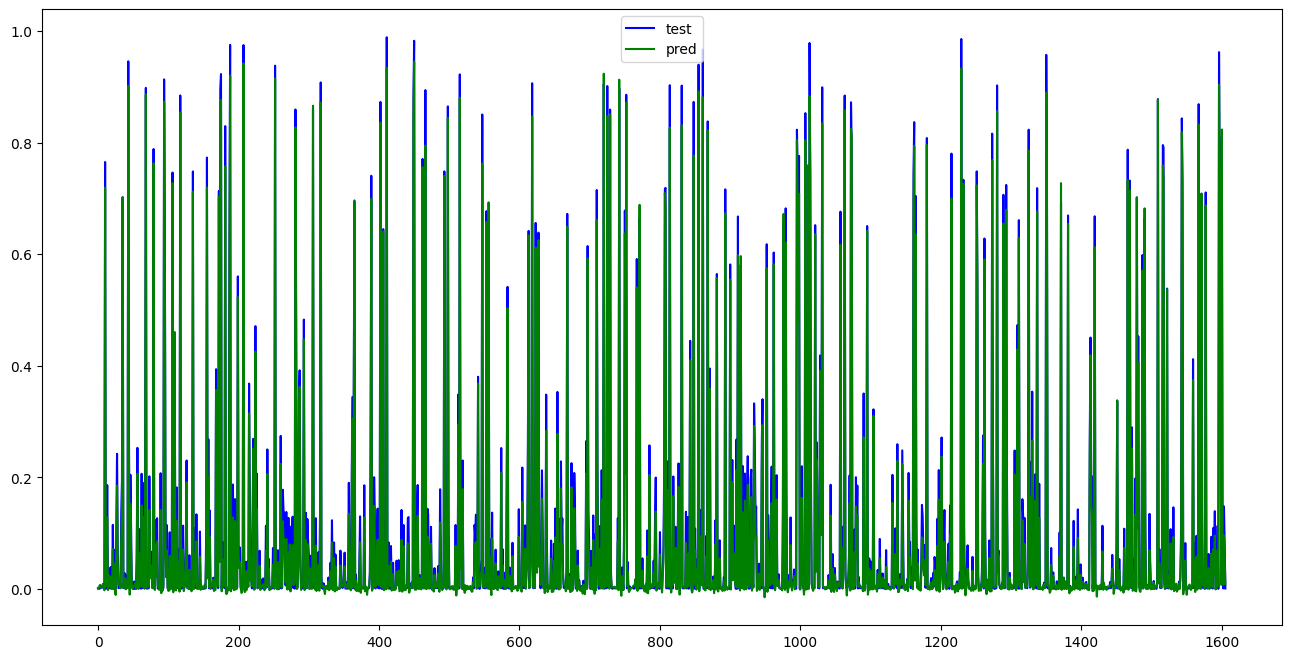

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color='blue', label='test')
plt.plot(y_pred, color='green', label='pred')
plt.legend()
plt.show()

In [ ]:
# Calculating Moving Averages
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# Calculating RSI
df['RSI'] = compute_rsi(df['Close'])

# Calculating MACD
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Calculating Bollinger Bands
window = 20
df['SMA_20'] = df['Close'].rolling(window=window).mean()
df['Upper_Band'] = df['SMA_20'] + 2 * df['Close'].rolling(window=window).std()
df['Lower_Band'] = df['SMA_20'] - 2 * df['Close'].rolling(window=window).std()

# Calculating Volatility Measures
df['Daily_Pct_Change'] = df['Close'].pct_change()
df['High_Low_Diff'] = df['High'] - df['Low']

# Calculating OBV
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# Calculating Stochastic Oscillator
low_min = df['Low'].rolling(window=14).min()
high_max = df['High'].rolling(window=14).max()
df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
# Opzionalmente, puoi calcolare anche il valore %D come media mobile dello Stochastic Oscillator
window_d = 3
df['%D'] = df['%K'].rolling(window=window_d).mean()

# Calculating ADL
clv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
df['ADL'] = (clv * df['Volume']).fillna(0).cumsum()

**Visualization**

Plot some of these indicators to visualize the trends

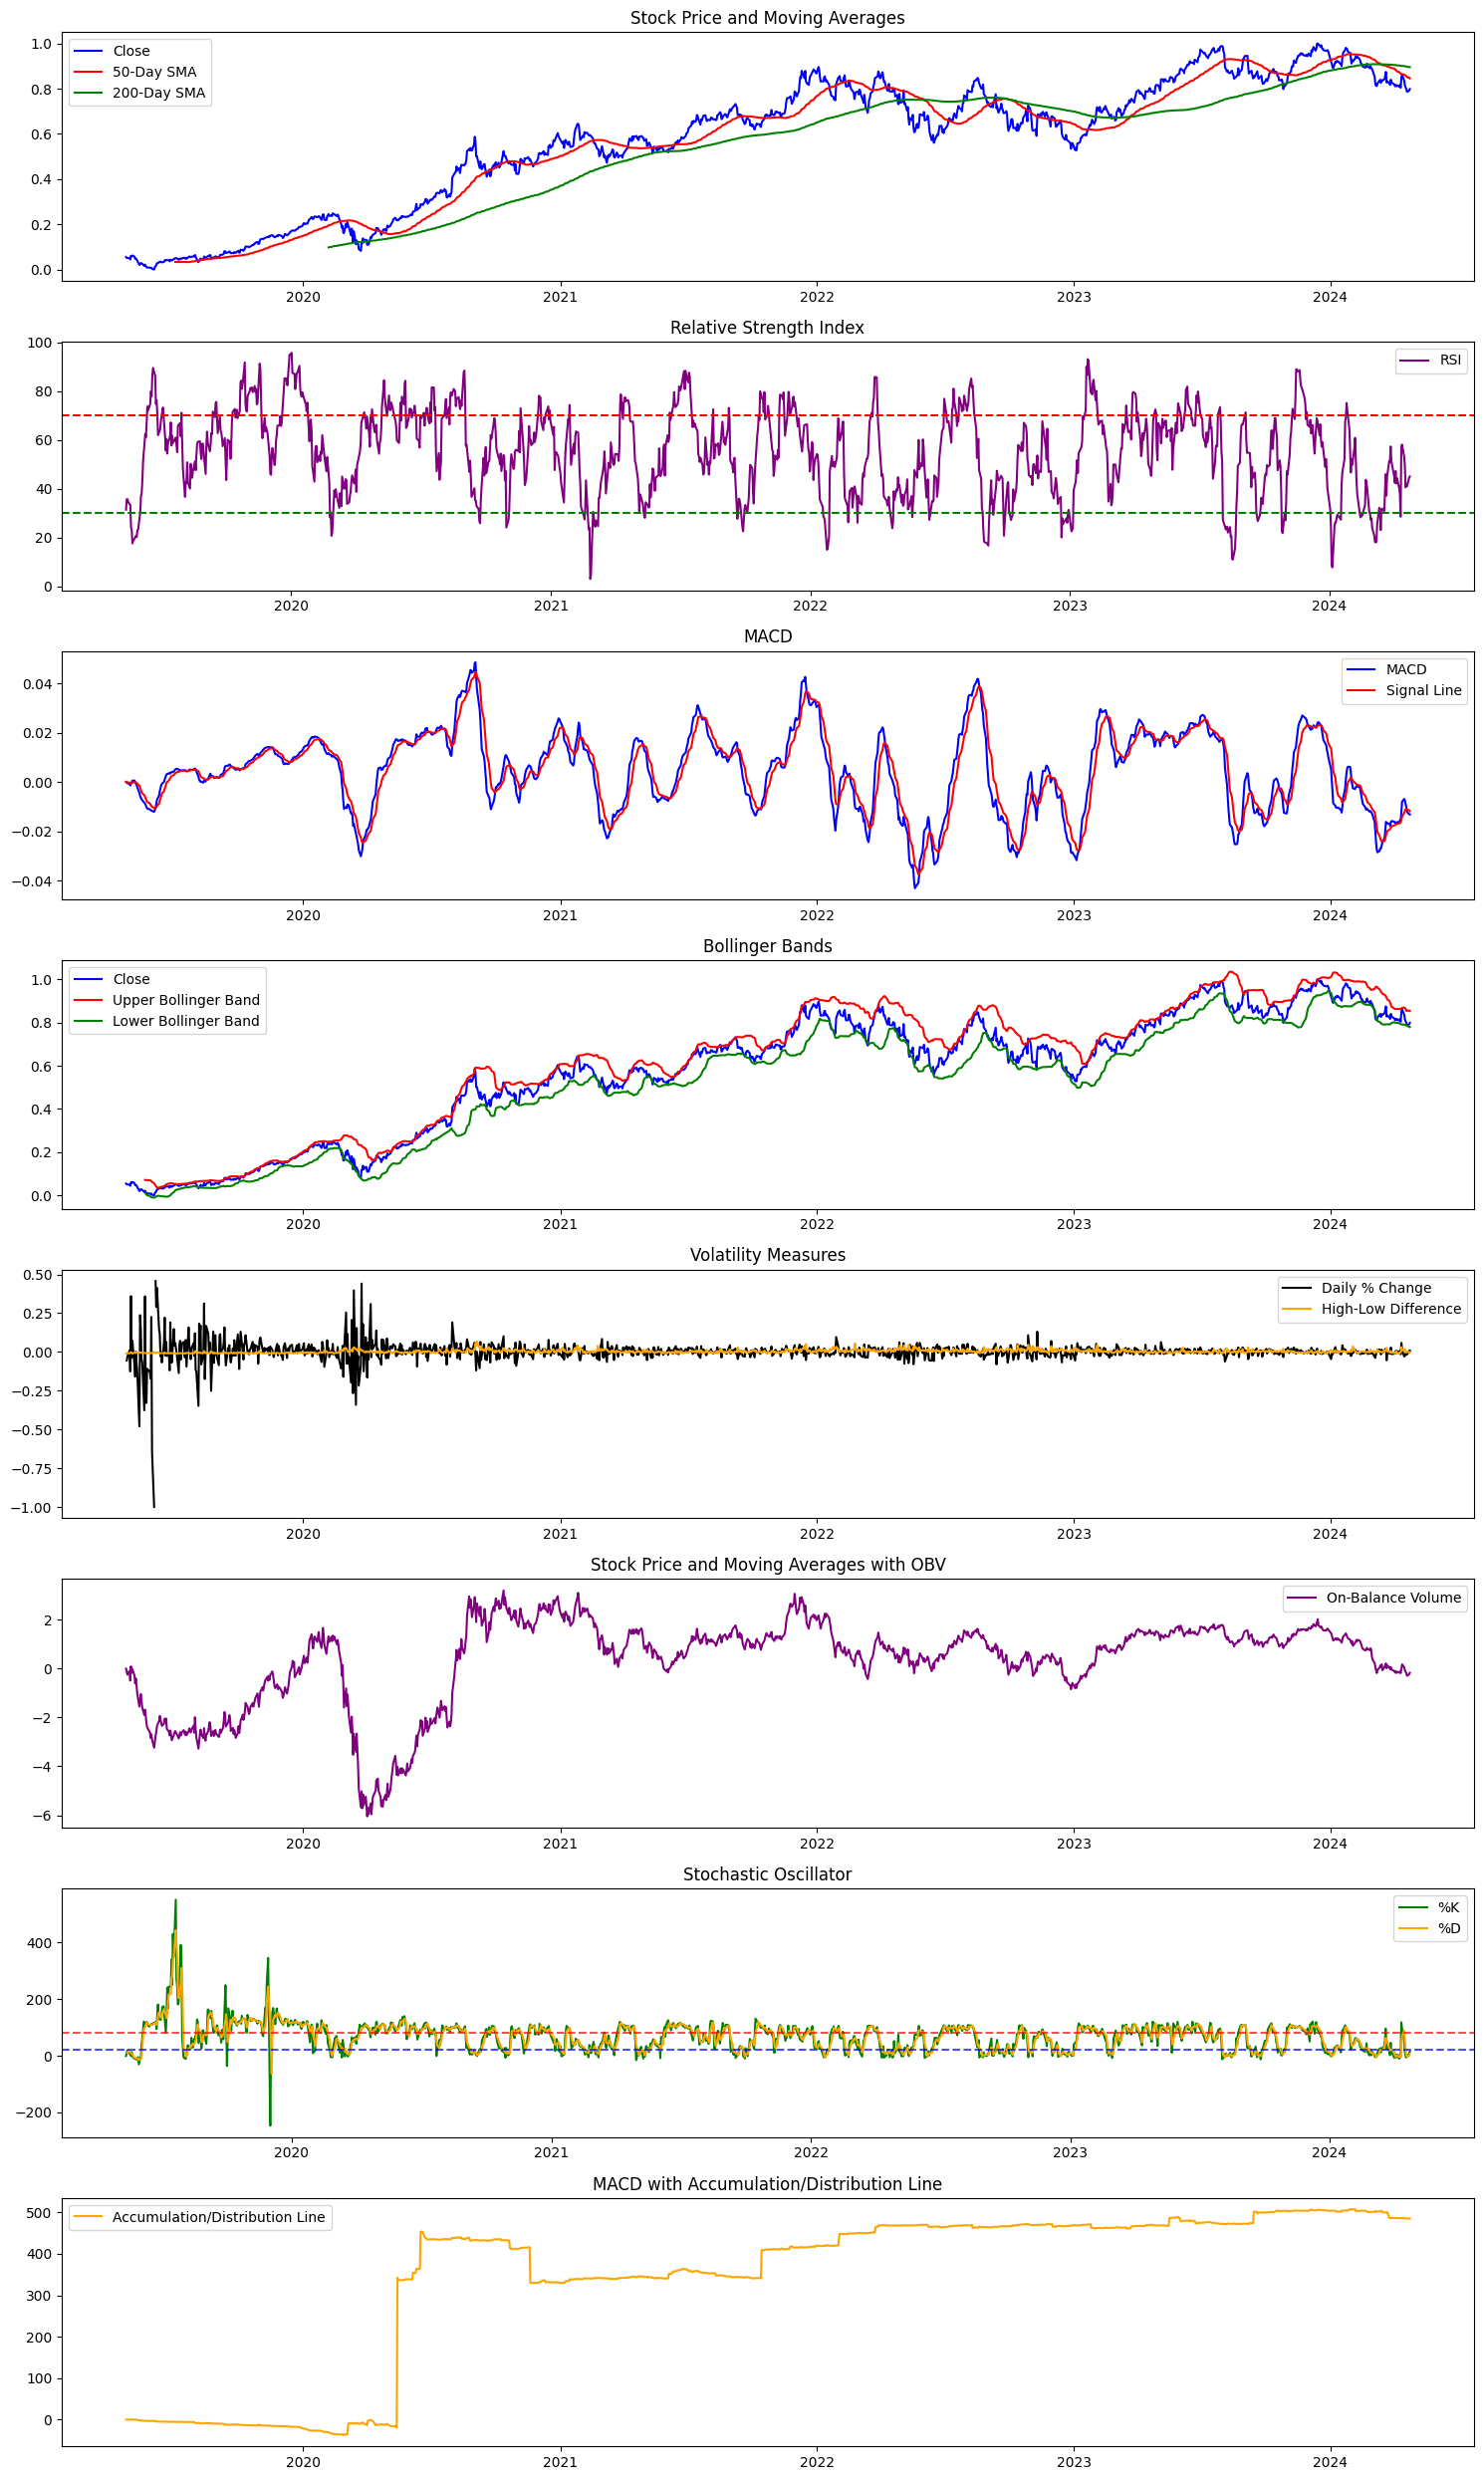

In [ ]:
# Create subplots
fig, axs = plt.subplots(8, 1, figsize=(15, 25))

# Plot Moving Averages
axs[0].plot(df['Close'], label='Close', color='blue')
axs[0].plot(df['SMA_50'], label='50-Day SMA', color='red')
axs[0].plot(df['SMA_200'], label='200-Day SMA', color='green')
axs[0].set_title('Stock Price and Moving Averages')
axs[0].legend()

# Plot RSI
axs[1].plot(df['RSI'], label='RSI', color='purple')
axs[1].axhline(70, linestyle='--', color='red')
axs[1].axhline(30, linestyle='--', color='green')
axs[1].set_title('Relative Strength Index')
axs[1].legend()

# Plot MACD
axs[2].plot(df['MACD'], label='MACD', color='blue')
axs[2].plot(df['MACD_Signal'], label='Signal Line', color='red')
axs[2].set_title('MACD')
axs[2].legend()

# Plot Bollinger Bands
axs[3].plot(df['Close'], label='Close', color='blue')
axs[3].plot(df['Upper_Band'], label='Upper Bollinger Band', color='red')
axs[3].plot(df['Lower_Band'], label='Lower Bollinger Band', color='green')
axs[3].set_title('Bollinger Bands')
axs[3].legend()

# Plot Volatility Measures
axs[4].plot(df['Daily_Pct_Change'], label='Daily % Change', color='black')
axs[4].plot(df['High_Low_Diff'], label='High-Low Difference', color='orange')
axs[4].set_title('Volatility Measures')
axs[4].legend()

# Plot OBV in the first subplot
axs[5].plot(df.index, df['OBV'], label='On-Balance Volume', color='purple')
axs[5].set_title('Stock Price and Moving Averages with OBV')
axs[5].legend()

# Plot Stochastic Oscillator in the second subplot
axs[6].plot(df.index, df['%K'], label='%K', color='green')
axs[6].plot(df.index, df['%D'], label='%D', color='orange')
axs[6].axhline(80, linestyle='--', color='red', alpha=0.7)
axs[6].axhline(20, linestyle='--', color='blue', alpha=0.7)
axs[6].set_title('Stochastic Oscillator')
axs[6].legend()

# Plot Accumulation/Distribution Line in the third subplot
axs[7].plot(df.index, df['ADL'], label='Accumulation/Distribution Line', color='orange')
axs[7].set_title('MACD with Accumulation/Distribution Line')
axs[7].legend()

plt.tight_layout()
plt.show()

**3. Splitting the Data**

Split the data into training and testing datasets.
The way you split the data can affect the performance of your model, especially in time series forecasting

In [ ]:
# Assuming 80-20 train-test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

**4. Model Building**

Build your LSTM model using a framework like TensorFlow or PyTorch. Here’s a simple example using TensorFlow/Keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

**5. Train the Model**

Fit the model on the training data

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
29/29 [==============================] - 5s 43ms/step - loss: 0.0581 - val_loss: 0.0158
Epoch 2/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 3/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
29/29 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/50
29/29 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 11/

**6. Evaluation and Prediction**

Finally, evaluate your model on the test set and make predictions

In [ ]:
predictions = model.predict(X_test)
# Scale back the predictions to the original range if needed
predictions_rescaled = scaler.inverse_transform(predictions)

# Evaluate the model
test_rescaled = scaler.inverse_transform(y_test)

8/8 [==============================] - 1s 5ms/step


This is a basic guide to get you started with using LSTM for stock price prediction. You can refine this by considering feature engineering, hyperparameter tuning, additional layers and neurons, or different types of LSTMs or RNNs.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate metrics
mse = mean_squared_error(test_rescaled, predictions_rescaled)
rmse = mse ** 0.5
mae = mean_absolute_error(test_rescaled, predictions_rescaled)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 39.43703285577592
Root Mean Squared Error: 6.279891149994235
Mean Absolute Error: 5.419917054792969


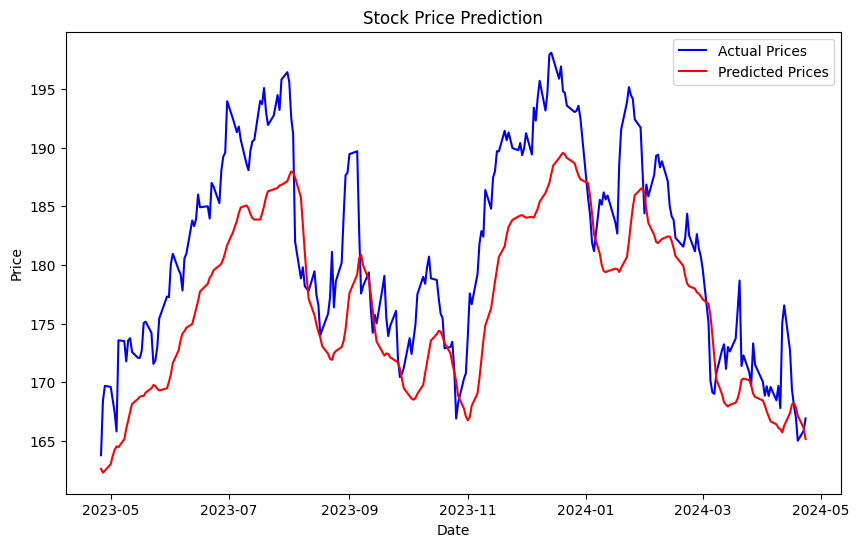

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_rescaled and predictions_rescaled are properly scaled back to the original range
dates_test = data.index[-len(predictions_rescaled):]  # Assuming dates are aligned with the test set

plt.figure(figsize=(10, 6))
plt.plot(dates_test, test_rescaled, label='Actual Prices', color='blue')
plt.plot(dates_test, predictions_rescaled, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

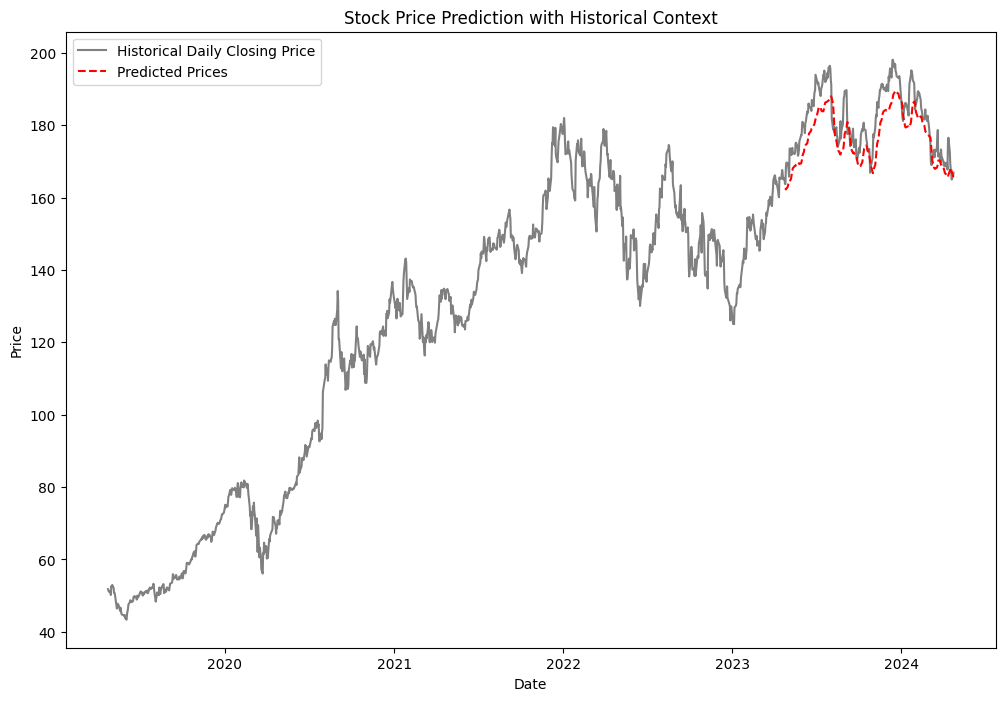

In [ ]:
# Full data plot with predictions overlaid
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['Close'], label='Historical Daily Closing Price', color='gray')
plt.plot(dates_test, predictions_rescaled, label='Predicted Prices', color='red', linestyle='--')
plt.title('Stock Price Prediction with Historical Context')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()